In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import enefit
import holidays
import datetime
import seaborn as sns


from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import KFold

/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
train = pd.read_csv('../Enefit_Datasets/train.csv')
gas_df = pd.read_csv('../Enefit_Datasets/gas_prices.csv')
electricity_df = pd.read_csv('../Enefit_Datasets/electricity_prices.csv')
client_df = pd.read_csv('../Enefit_Datasets/client.csv')
fw_df = pd.read_csv('../Enefit_Datasets/forecast_weather.csv')
hw_df = pd.read_csv('../Enefit_Datasets/historical_weather.csv')
locations = pd.read_csv('../Enefit_Datasets/county_lon_lats.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../Enefit_Datasets/county_lon_lats.csv'

In [3]:
def TrainPreprocessing(train, client_df, fw_df, electricity_df, gas_df, locations, hw_df):
    '''Train data preprocessing'''
    
    # Drop nan values
    train = train[train['target'].notnull()]
    
    # Converting to datetime & date feature engineering
    train['datetime'] = pd.to_datetime(train['datetime'], utc=True)
    
    train['year'] = train['datetime'].dt.year
    train['quarter'] = train['datetime'].dt.quarter
    train['month'] = train['datetime'].dt.month
    train['week'] = train['datetime'].dt.isocalendar().week
    train['day'] = train['datetime'].dt.day
    train['hour'] = train['datetime'].dt.hour
    train['dayofweek'] = train['datetime'].dt.dayofweek
    train['dayofyear'] = train['datetime'].dt.dayofyear

    train['week'] = train['week'].astype('int32')
    
    train["jan_flag"] = (train["month"] == 1).astype(int)

    # Client data processing
    # Subtracting 2 from data_block_id. Data is two steps ahead
    client_df['data_block_id'] -= 2
    
    # Average installed capacity. (installed_capacity / eic_count)
    client_df['avg_installed_cap'] = client_df['installed_capacity'] / client_df['eic_count']

    
    # Electricity data processing
    # Renaming (forecast_date) to (datetime) for merging with the train data later
    electricity_df = electricity_df.rename(columns= {'forecast_date' : 'datetime'})
    
    # Converting (datetime) column to datetime
    electricity_df['datetime'] = pd.to_datetime(electricity_df['datetime'], utc= True)
    
    electricity_df['hour'] = electricity_df['datetime'].dt.hour
    
    # Locations data processing
    # Drop
    locations = locations.drop('Unnamed: 0', axis= 1) 
        

    # Forecast Weather 
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    
    # 1.
    fw_df[['latitude', 'longitude']] = fw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    fw_df = fw_df.merge(locations, how='left', on=['latitude', 'longitude'])
    
    # 3.
    fw_df.dropna(axis=0, inplace=True)
    
    # 4.
    fw_df['county'] = fw_df['county'].astype('int64')
    
    # 5.
    fw_df.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead',
               'data_block_id'], axis=1, inplace=True)
    
    # 6.
    fw_df.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
    fw_df['datetime'] = pd.to_datetime(fw_df['datetime'], utc=True)
    
    # 7.
    fw_df_mean = fw_df.groupby([fw_df['datetime']
                                .dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1)
                                                                           .columns)].mean().reset_index()
    fw_df_mean['datetime'] = pd.to_datetime(fw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    # 8. 
    fw_df_county = fw_df.groupby(['county', fw_df['datetime'].dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1).columns)].mean().reset_index()
    fw_df_county['datetime'] = pd.to_datetime(fw_df_county['datetime'].dt.to_timestamp(), utc=True)

    
    # Historical weather df processing
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    # 9. Merge data_block_id back to new county df
   
    # 1.
    hw_df[['latitude', 'longitude']] = hw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    hw_df = hw_df.merge(locations, how='left', on=['longitude', 'latitude'])
    
    # 3.
    hw_df.dropna(axis=0, inplace=True)
    
    # 4.
    hw_df['county'] = hw_df['county'].astype('int64')
    
    # 5.
    hw_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
    
    # 6.
    hw_df['datetime'] = pd.to_datetime(hw_df['datetime'], utc=True)
    
    # 7.
    hw_df_mean = hw_df.groupby([hw_df['datetime']
                                .dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1)
                                                                           .columns)].mean().reset_index()
    hw_df_mean['datetime'] = pd.to_datetime(hw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    hw_df_mean = hw_df_mean.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    
    # 8. 
    hw_df_county = hw_df.groupby(['county', hw_df['datetime'].dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()
    hw_df_county['datetime'] = pd.to_datetime(hw_df_county['datetime'].dt.to_timestamp(), utc=True)
    hw_df_county = hw_df_county.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_county.reset_index()
    
    # Merge the data into train set
    # 1. Merge client 
    # 2. Merge gas
    # 3. Merge electricity
    # 4. Merge forecast weather
    # 5. Merge forecast weather by county
    # 6. Add hour col to hist weather and hist county. Drop dups and datetime col
    # 7. Merge hist weather menas
    # 8. Merge hist weather means by county
    # 9. Fill null values with forward and backward method
    # 10. Drop un-necessary cols...?

    
    # 1
    train = train.merge(client_df.drop(columns = ['date']), how='left', on = ['data_block_id', 'county', 'is_business', 'product_type'])
    
    # 2
    train = train.merge(gas_df[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    # 3
    train = train.merge(electricity_df[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour','data_block_id'])
    
    # 4 
    train = train.merge(fw_df_mean, how='left', on='datetime')
    
    # 5 
    train = train.merge(fw_df_county, how='left', on=['datetime', 'county'], suffixes = ('_fcast_mean', '_fcast_mean_by_county'))
    
    # 6
    hw_df_mean['hour'] = hw_df_mean['datetime'].dt.hour
    hw_df_county['hour'] = hw_df_county['datetime'].dt.hour
    
    hw_df_mean.drop_duplicates(inplace=True)
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_mean.drop('datetime', axis=1, inplace=True)
    hw_df_county.drop('datetime', axis=1, inplace=True)

    # 7
    train = train.merge(hw_df_mean, how='left', on=['data_block_id', 'hour'])
    
    # 8 
    train = train.merge(hw_df_county, how='left', on=['data_block_id', 'county', 'hour'], suffixes= ('_hist_mean', '_hist_mean_by_county'))
    
    # 9
    train = train.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    # 10
    train.drop(['row_id', 'data_block_id'], axis = 1, inplace = True)
    
    return train

In [4]:
def is_holiday(dataframe):
    '''Creates is_holiday boolean column for Estonian country wide holidays'''
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2024))
    estonian_holidays = list(estonian_holidays.keys())

    
    dataframe['is_holiday'] = dataframe.apply(lambda row: (datetime.date(row['year'], row['month'], row['day']) in estonian_holidays) * 1, axis=1)
    return dataframe

In [5]:
def create_target_lags(train, N_lags):
    '''Lag target variables are a form of feature engineering that gives
    the model context for what the target was N days ago'''
    
    # Store datetime column in a python object
    og_datetime = train['datetime']
    
    # Store important variables to reference with target
    target_and_friends = train[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create lagged targets
    for lag in range(2, N_lags + 1): # Starts at 2, ends at set day
        target_and_friends['datetime'] = og_datetime + pd.DateOffset(lag) # Shifts dates forward by set amount (lag)
        train = train.merge(target_and_friends, how='left', on=['datetime', 'prediction_unit_id', 'is_consumption'], suffixes = ('', f'_{lag}_days_ago'))
        
    return train

In [6]:
# Train preprocessing
train = TrainPreprocessing(train, client_df, fw_df, electricity_df, gas_df, locations, hw_df)

# Add holidays
train = is_holiday(train)

# Add target lags
N_lags = 7
train = create_target_lags(train, N_lags) #Any number after 2
train.head()

/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_18005/2849449000.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['datetime'] = pd.to_datetime(train['datetime'], utc=True)
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_18005/2849449000.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['year'] = train['datetime'].dt.year
/var/folders/kc/j9thmgvn1x74gl5srr5tl9mm0000gn/T/ipykernel_18005/2849449000.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

index  county  is_business  product_type  target  is_consumption  \
0      0       0            0             1   0.713               0   
1      1       0            0             1  96.590               1   
2      2       0            0             2   0.000               0   
3      3       0            0             2  17.314               1   
4      4       0            0             3   2.904               0   

                   datetime  prediction_unit_id  year  quarter  ...  \
0 2021-09-01 00:00:00+00:00                   0  2021        3  ...   
1 2021-09-01 00:00:00+00:00                   0  2021        3  ...   
2 2021-09-01 00:00:00+00:00                   1  2021        3  ...   
3 2021-09-01 00:00:00+00:00                   1  2021        3  ...   
4 2021-09-01 00:00:00+00:00                   2  2021        3  ...   

   shortwave_radiation_hist_mean_by_county  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   direct_solar_radiation_hist_mean_by_county  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   diffuse_radiation_hist_mean_by_county  is_holiday  target_2_days_ago  \
0                                    0.0           0                NaN   
1                                    0.0           0                NaN   
2                                    0.0           0                NaN   
3                                    0.0           0                NaN   
4                                    0.0           0                NaN   

   target_3_days_ago  target_4_days_ago  target_5_days_ago  target_6_days_ago  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   
2                NaN                NaN                NaN                NaN   
3                NaN                NaN                NaN                NaN   
4                NaN                NaN                NaN                NaN   

   target_7_days_ago  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 81 columns]

In [8]:
# Drop year column as its no longer needed
train.drop(['year'], axis=1, inplace=True)

In [9]:
# Further feature engineering

# Convert datetime to integer for date features
train['datetime'] = train['datetime'].astype('int64')

train['sin_hour']= (np.pi * np.sin(train['hour']) / 12)
train['cos_hour']= (np.pi * np.cos(train['hour']) / 12)
train['sin_dayofyear']= (np.pi * np.sin(train['dayofyear']) / 183)
train['cos_dayofyear']= (np.pi * np.cos(train['dayofyear']) / 183)
train['target_mean']= train[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].mean(1)
train['target_std']= train[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].std(1)
train['target_var']= train[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].var(1)


In [10]:
train.columns

Index(['index', 'county', 'is_business', 'product_type', 'target',
       'is_consumption', 'datetime', 'prediction_unit_id', 'quarter', 'month',
       'week', 'day', 'hour', 'dayofweek', 'dayofyear', 'eic_count',
       'installed_capacity', 'avg_installed_cap', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'euros_per_mwh', 'temperature_fcast_mean',
       'dewpoint_fcast_mean', 'cloudcover_high_fcast_mean',
       'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean',
       'cloudcover_total_fcast_mean', '10_metre_u_wind_component_fcast_mean',
       '10_metre_v_wind_component_fcast_mean',
       'direct_solar_radiation_fcast_mean',
       'surface_solar_radiation_downwards_fcast_mean', 'snowfall_fcast_mean',
       'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county',
       'dewpoint_fcast_mean_by_county', 'cloudcover_high_fcast_mean_by_county',
       'cloudcover_low_fcast_mean_by_county',
       'cloudcover_mid_fcast_mean_by_county',
       'cloudco

In [11]:
# Log columns with outliers
to_log= ['installed_capacity', 'euros_per_mwh', 'temperature_fcast_mean', 'dewpoint_fcast_mean',
        'cloudcover_high_fcast_mean', 'cloudcover_low_fcast_mean', 'cloudcover_mid_fcast_mean', 'cloudcover_total_fcast_mean',
        '10_metre_u_wind_component_fcast_mean', '10_metre_v_wind_component_fcast_mean', 'direct_solar_radiation_fcast_mean',
        'snowfall_fcast_mean', 'total_precipitation_fcast_mean', 'temperature_fcast_mean_by_county', 'dewpoint_fcast_mean_by_county',
        'cloudcover_high_fcast_mean_by_county', 'cloudcover_low_fcast_mean_by_county', 'cloudcover_mid_fcast_mean_by_county',
        'cloudcover_total_fcast_mean_by_county', '10_metre_u_wind_component_fcast_mean_by_county', '10_metre_v_wind_component_fcast_mean_by_county',
        'surface_solar_radiation_downwards_fcast_mean_by_county', 'snowfall_fcast_mean_by_county', 'total_precipitation_fcast_mean_by_county',
        'rain_hist_mean', 'snowfall_hist_mean', 'windspeed_10m_hist_mean_by_county', 'target_2_days_ago', 'target_3_days_ago',
        'target_4_days_ago', 'target_5_days_ago', 'target_6_days_ago', 'target_7_days_ago', 'target_mean', 'target_std']
for i in to_log:
    train[f"log_{i}"]= np.where((train[i])!= 0, np.log(train[i]),0) #Create new col and log the value if not 0
    

/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*i

In [12]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017824 entries, 0 to 2017823
Data columns (total 122 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    index                                                       int64  
 1    county                                                      int64  
 2    is_business                                                 int64  
 3    product_type                                                int64  
 4    target                                                      float64
 5    is_consumption                                              int64  
 6    datetime                                                    int64  
 7    prediction_unit_id                                          int64  
 8    quarter                                                     int64  
 9    month                                                       int64 

In [34]:
# Set the display options to show all rows and columns
pd.set_option('display.max_columns', None)

# Your code here
train_viz = train.groupby(['hour', 'county'])
train_viz_df = pd.DataFrame(train_viz)

train_viz.head(20)

index  county  is_business  product_type   target  is_consumption  \
0          0       0            0             1    0.713               0   
1          1       0            0             1   96.590               1   
2          2       0            0             2    0.000               0   
3          3       0            0             2   17.314               1   
4          4       0            0             3    2.904               0   
...      ...     ...          ...           ...      ...             ...   
29135  29135      12            1             3  635.863               1   
29206  29206       6            1             3    0.000               0   
29207  29207       6            1             3  128.151               1   
29256  29256      12            1             3    0.000               0   
29257  29257      12            1             3  608.128               1   

                  datetime  prediction_unit_id  quarter  month  week  day  \
0      1630454400000000000                   0        3      9    35    1   
1      1630454400000000000                   0        3      9    35    1   
2      1630454400000000000                   1        3      9    35    1   
3      1630454400000000000                   1        3      9    35    1   
4      1630454400000000000                   2        3      9    35    1   
...                    ...                 ...      ...    ...   ...  ...   
29135  1631311200000000000                  49        3      9    36   10   
29206  1631314800000000000                  24        3      9    36   10   
29207  1631314800000000000                  24        3      9    36   10   
29256  1631314800000000000                  49        3      9    36   10   
29257  1631314800000000000                  49        3      9    36   10   

       hour  dayofweek  dayofyear  eic_count  installed_capacity  \
0         0          2        244      108.0              952.89   
1         0          2        244      108.0              952.89   
2         0          2        244       17.0              166.40   
3         0          2        244       17.0              166.40   
4         0          2        244      688.0             7207.88   
...     ...        ...        ...        ...                 ...   
29135    22          4        253        9.0              241.50   
29206    23          4        253        6.0              324.20   
29207    23          4        253        6.0              324.20   
29256    23          4        253        9.0              241.50   
29257    23          4        253        9.0              241.50   

       avg_installed_cap  lowest_price_per_mwh  highest_price_per_mwh  \
0               8.823056                 50.15                  69.99   
1               8.823056                 50.15                  69.99   
2               9.788235                 50.15                  69.99   
3               9.788235                 50.15                  69.99   
4              10.476570                 50.15                  69.99   
...                  ...                   ...                    ...   
29135          26.833333                 44.96                  47.72   
29206          54.033333                 44.96                  47.72   
29207          54.033333                 44.96                  47.72   
29256          26.833333                 44.96                  47.72   
29257          26.833333                 44.96                  47.72   

       euros_per_mwh  temperature_fcast_mean  dewpoint_fcast_mean  \
0              71.36               13.014066            10.531545   
1              71.36               13.014066            10.531545   
2              71.36               13.014066            10.531545   
3              71.36               13.014066            10.531545   
4              71.36               13.014066            10.531545   
...              ...                     ...                 

In [13]:
import dask.dataframe as dd

# Convert pandas DataFrame to Dask DataFrame
dask_df = dd.from_pandas(train, npartitions=5)

# Separate features and target variable
X = dask_df.drop('target', axis = 1)
y = dask_df['target']

# Split data into train and test sets
X_train, X_test = X.random_split([0.8, 0.2], random_state=42)
y_train, y_test = y.random_split([0.8, 0.2], random_state=42)

# Storing production targets seperately
X2 = dask_df[dask_df['is_consumption'] == 0].drop('target', axis= 1)
y2 = dask_df[dask_df['is_consumption'] == 0]['target']

# Split data into train and test sets
X2_train, X2_test = X2.random_split([0.8, 0.2], random_state=42)
y2_train, y2_test = y2.random_split([0.8, 0.2], random_state=42)


https://app.neptune.ai/dextercorley19/Enefit/e/EN-13
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/dextercorley19/Enefit/e/EN-13/metadata


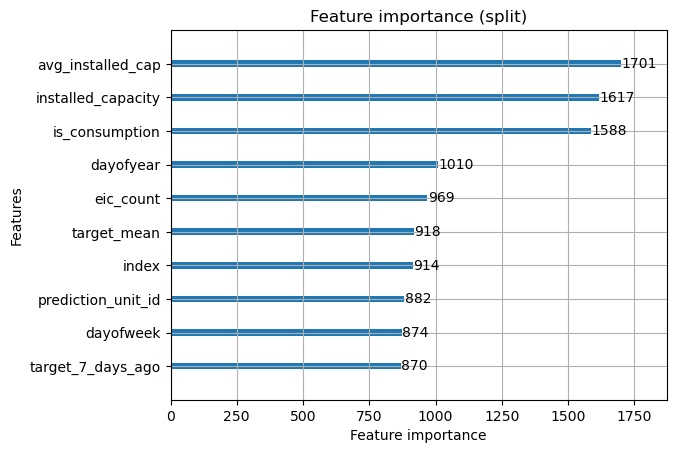

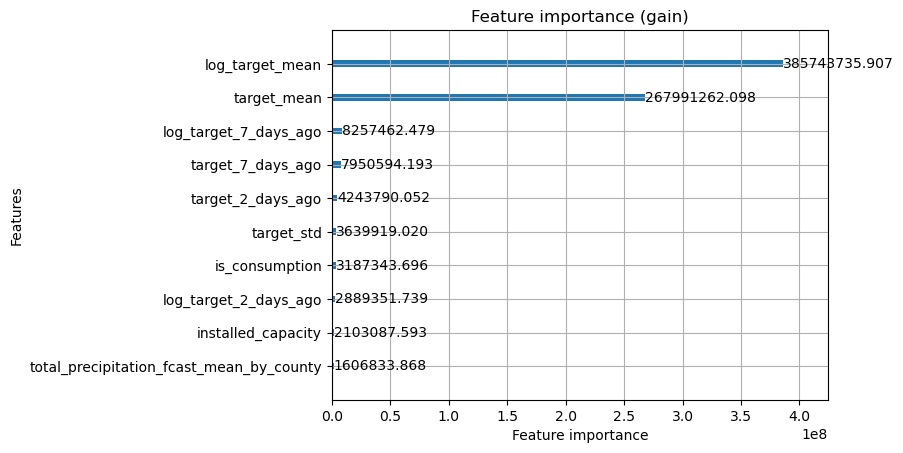

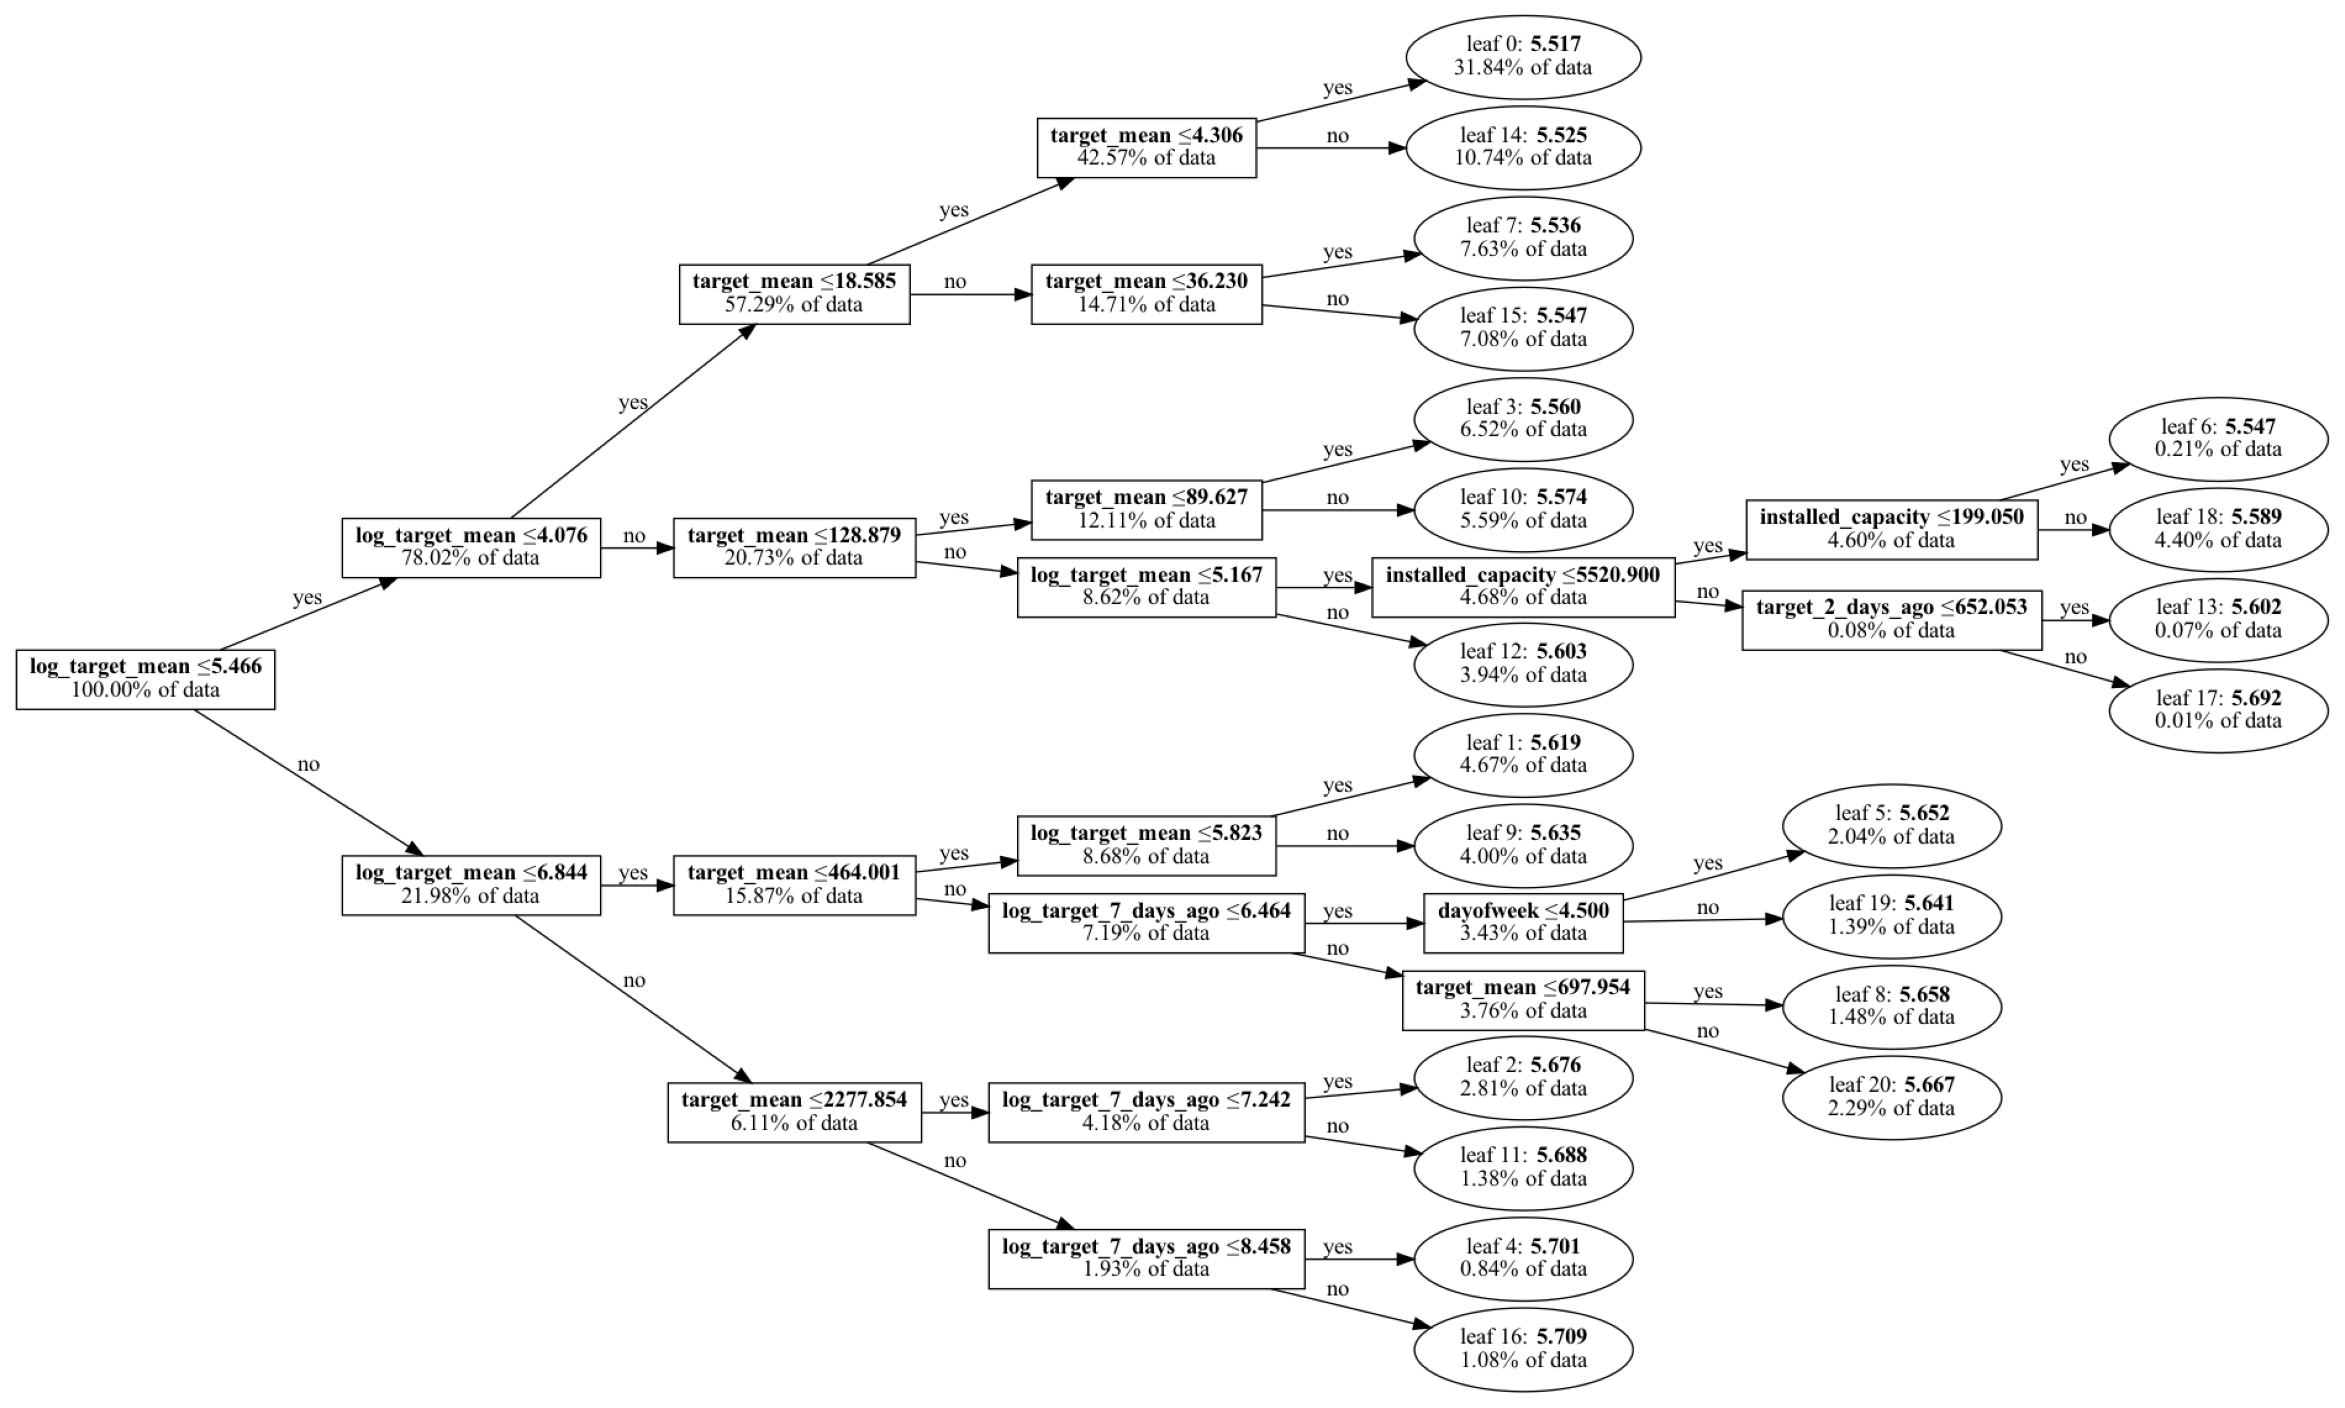

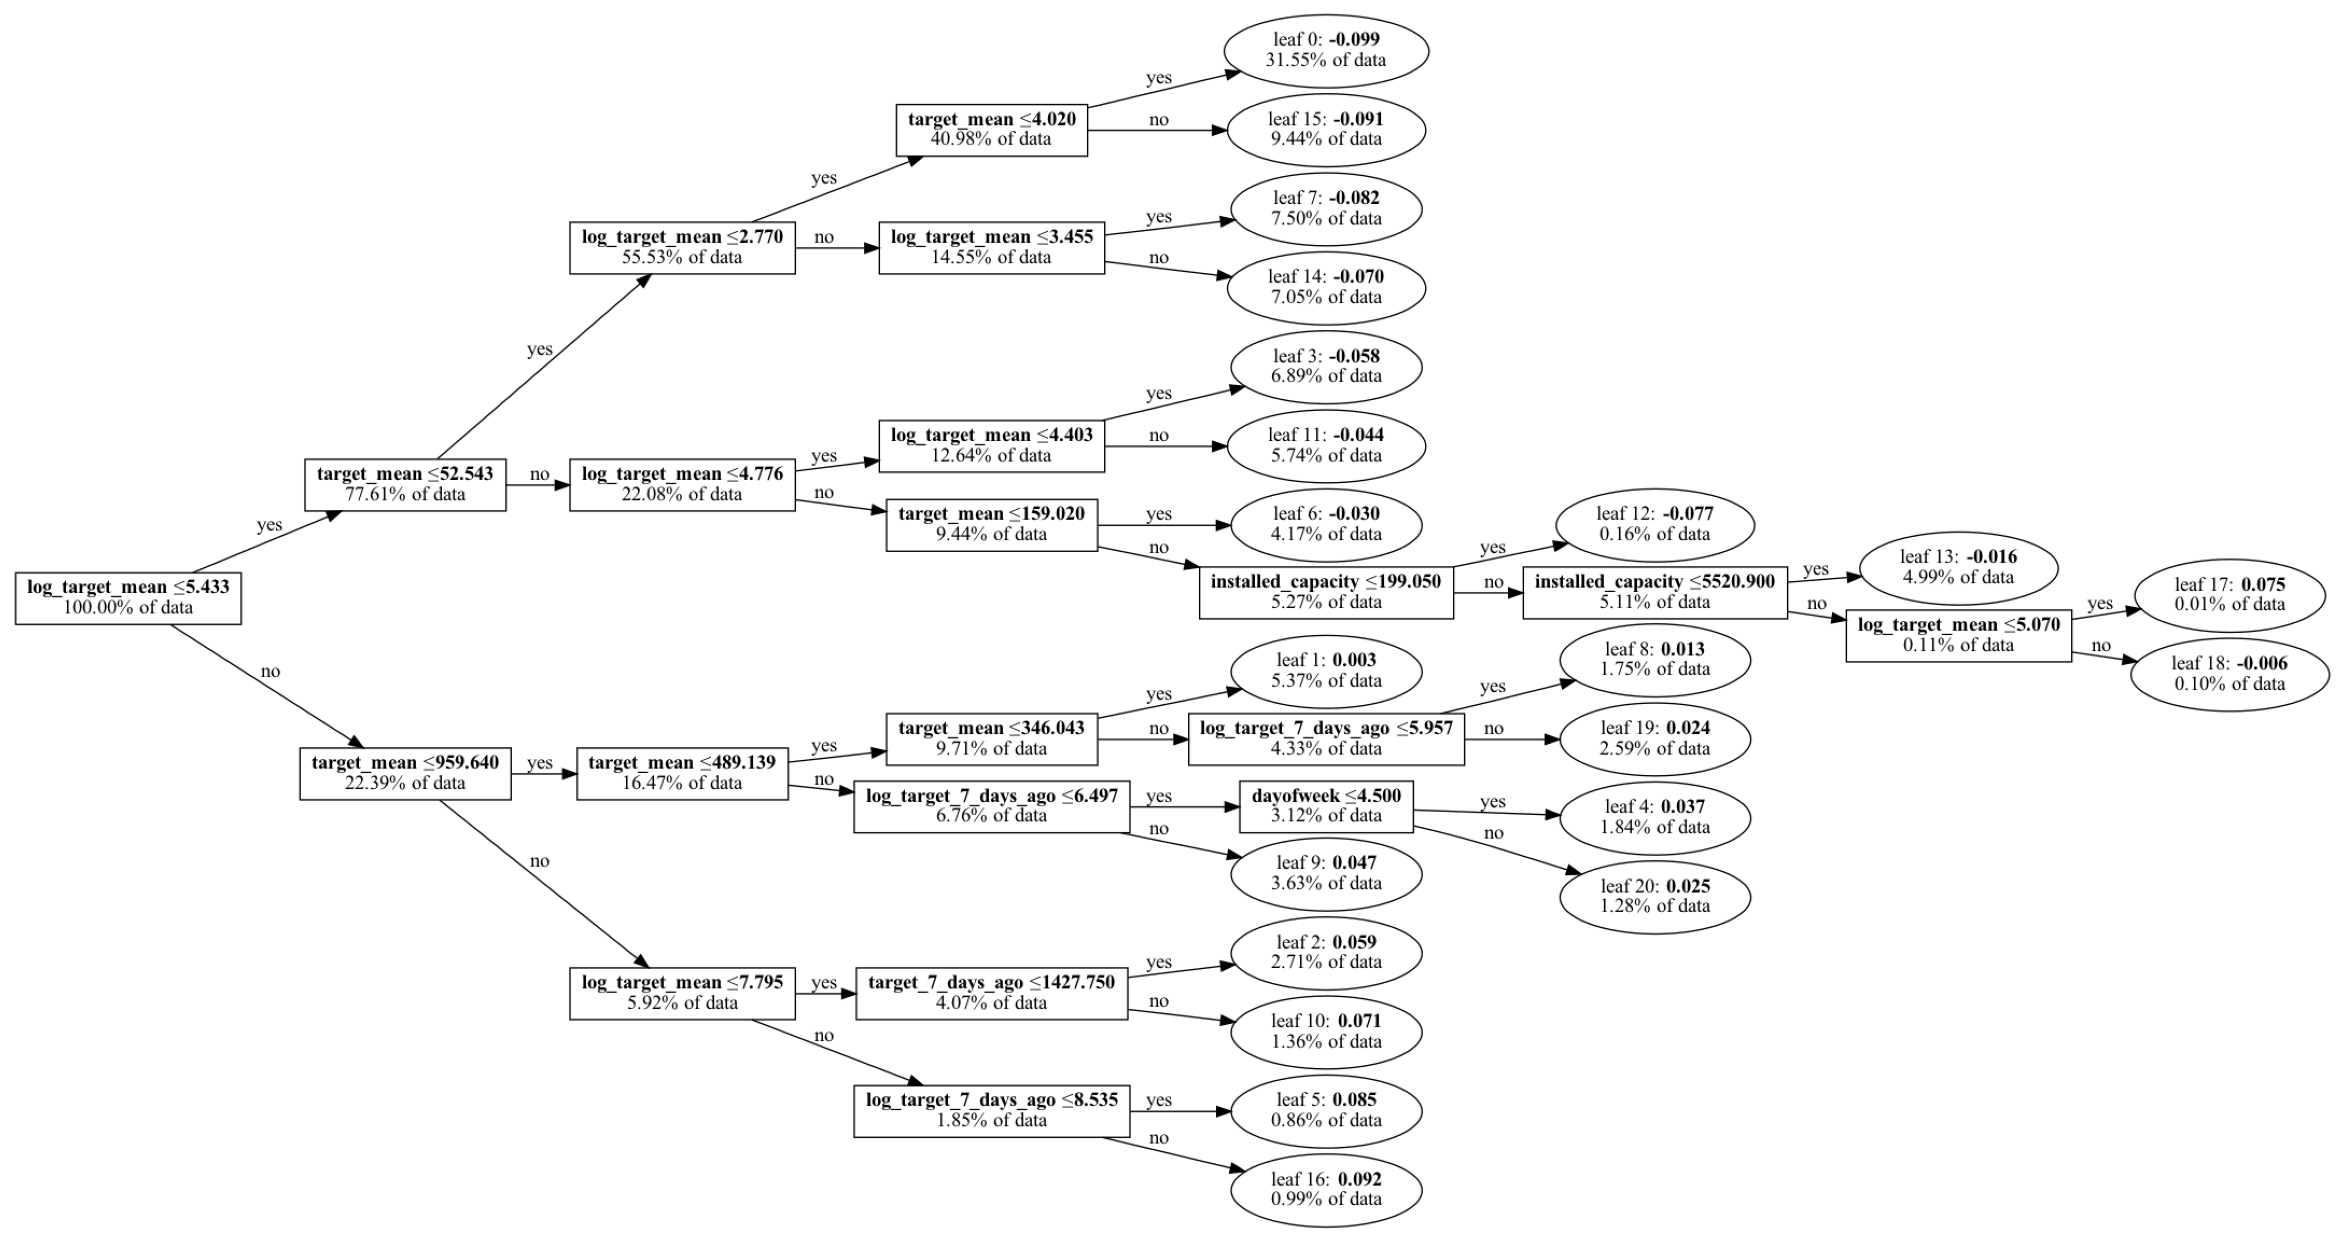

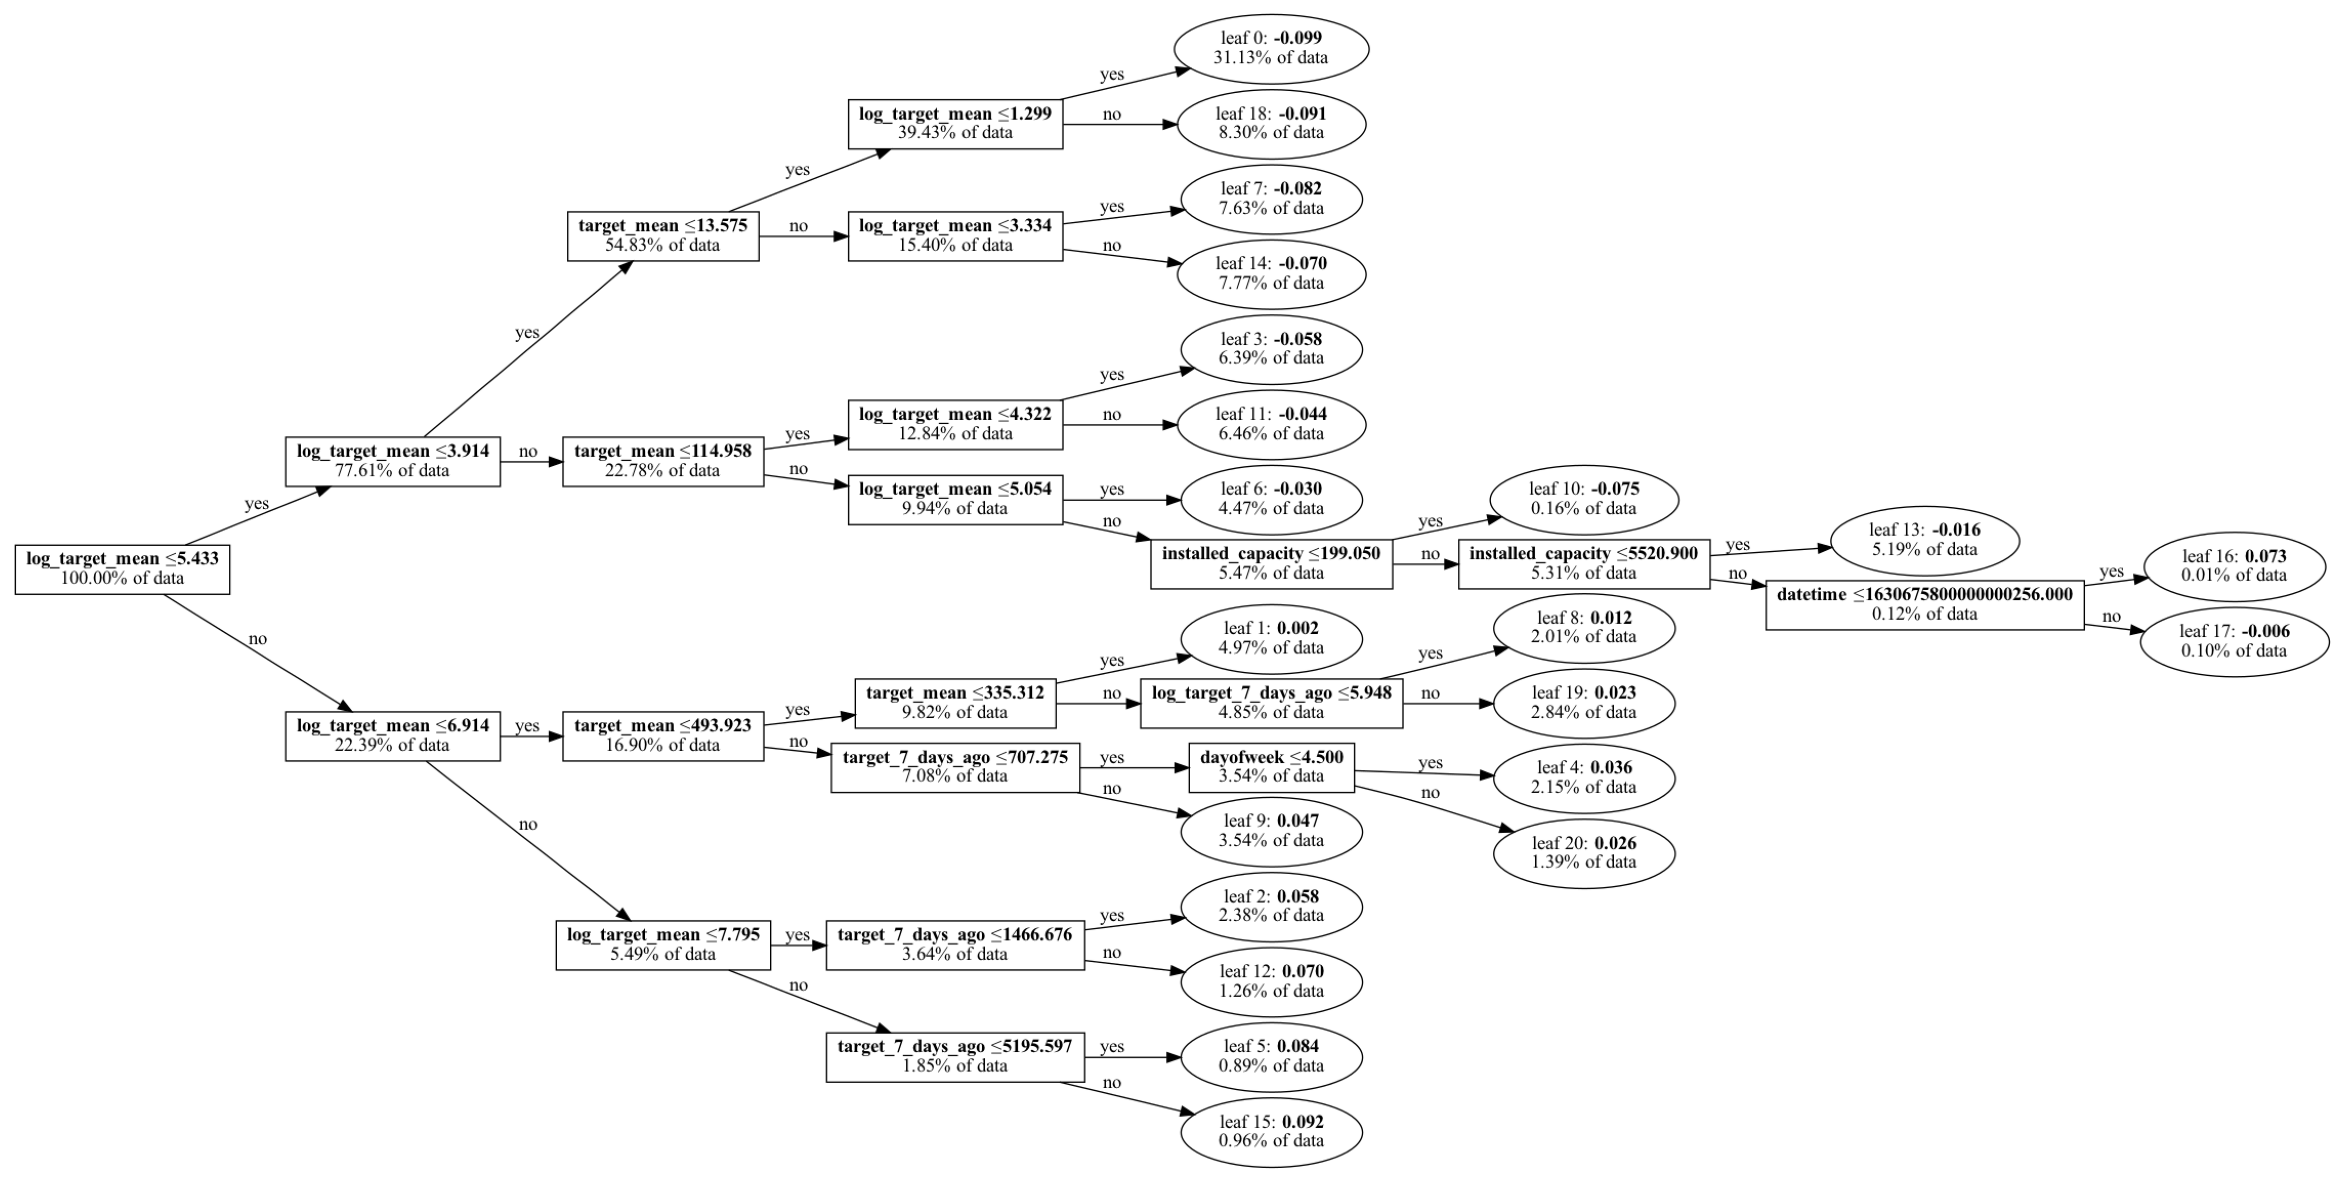

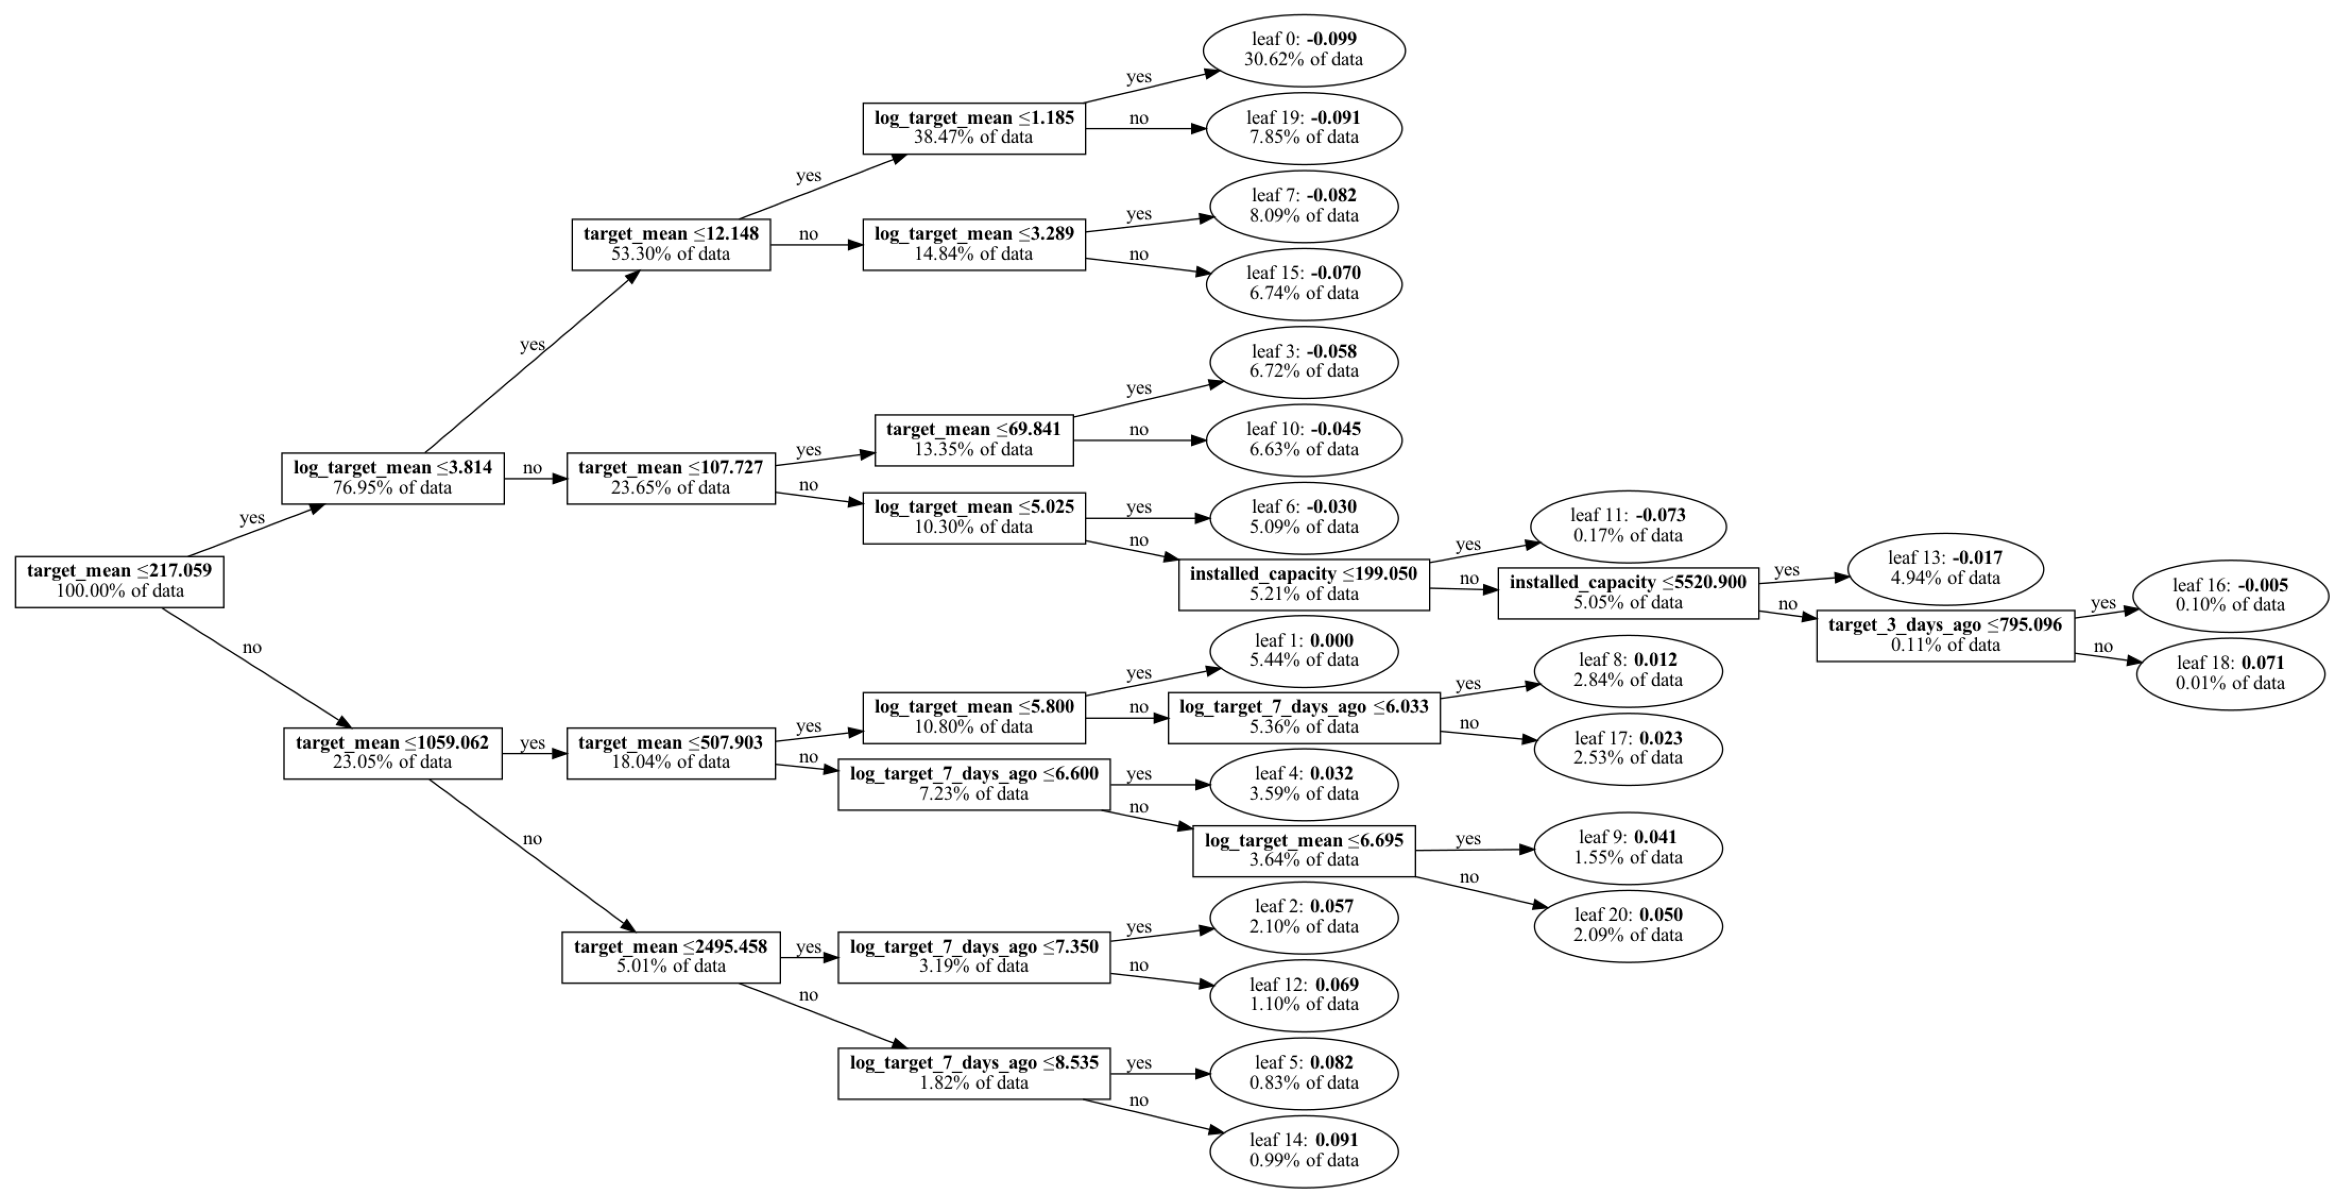

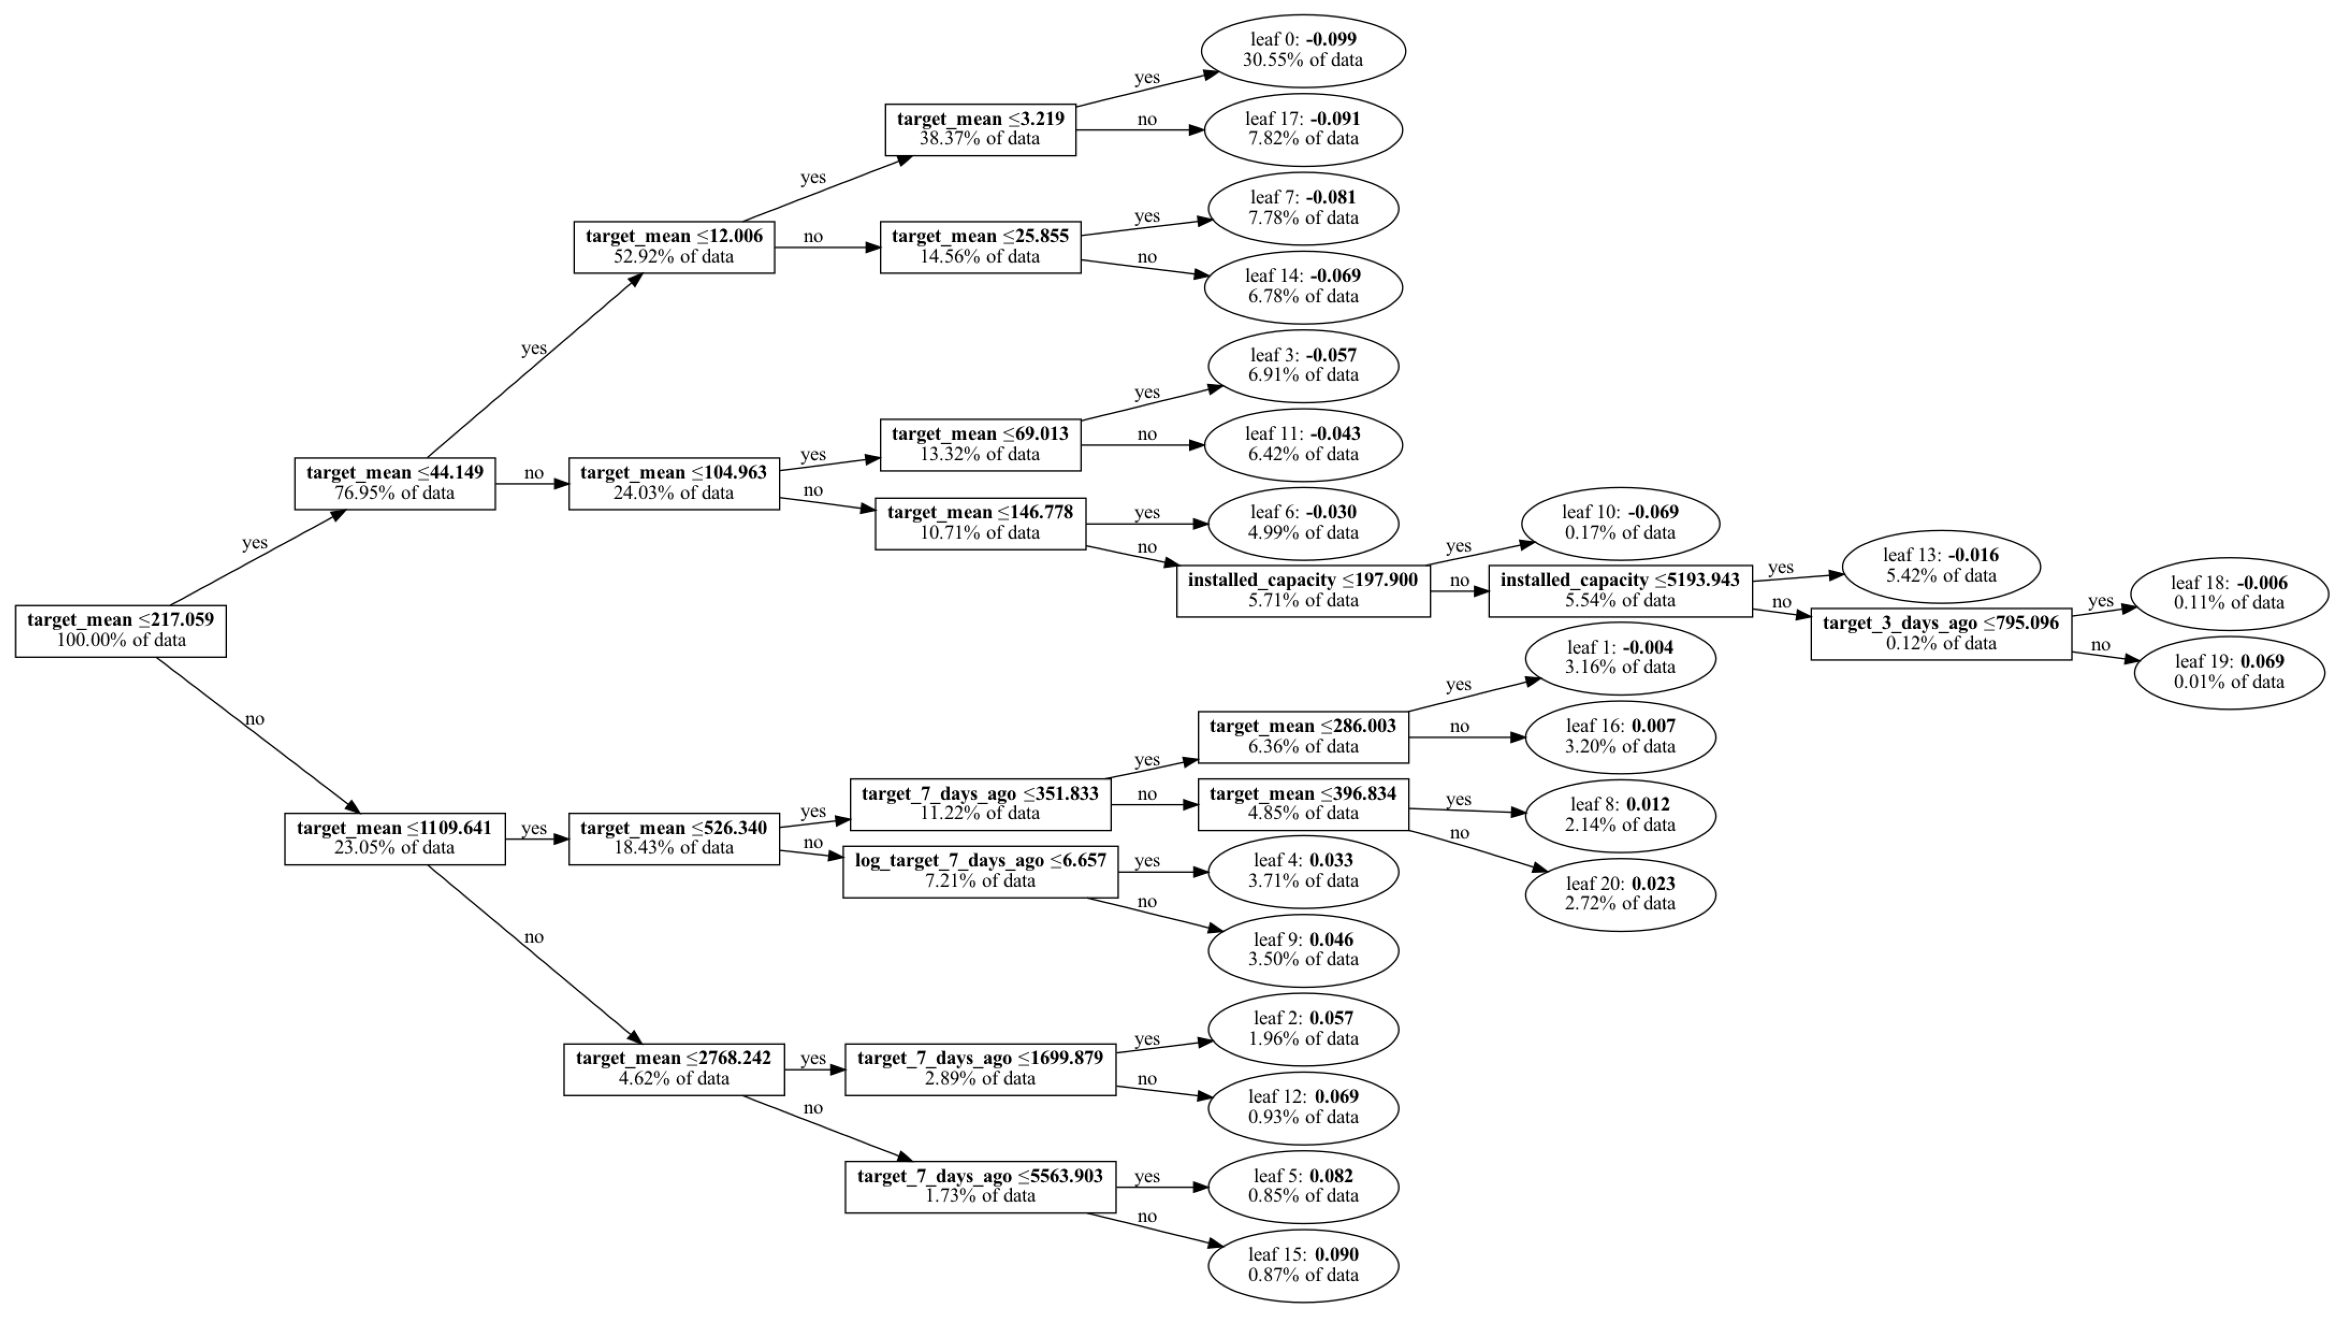

In [29]:
import lightgbm as lgb
import neptune
from neptune.integrations.lightgbm import NeptuneCallback, create_booster_summary
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import dask

# Main Model 

run = neptune.init_run(
    project="dextercorley19/Enefit",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOThkMDNhZS1kNTQ4LTRjYmItOTE3ZC1jODI0NWVhNjRmOGYifQ==",
    name="train-cls", # Optional, but you should probably give it a name. Defaults to 'neptune-run-$run_id' if not specified. 
    tags=["lgbm-integration", "train", "main-model" "2000 rounds", "100 early stop"], # Optional, list of strings. Defaults to empty list if not specified. 
) 

# Create Neptune callback
neptune_callback = NeptuneCallback(run=run) # Optional, but you should probably use it

# Prepare data
X_train, X_test, y_train, y_test = dask.compute(X_train, X_test, y_train, y_test)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Define parameters
params = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "metric": ["mean_absolute_error"],
    'verbose': -1,
    "num_leaves": 21,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    'min_data_in_leaf': 198,
    'max_depth': 15,
    'max_bin': 835,
    'lambda_l1': 3.6277555139102864,
    'lambda_l2': 1.6591278779517808,
    "early_stopping_round": 100
}

# Train the model
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=["training", "validation"],
    callbacks=[neptune_callback],
)

y_pred = gbm.predict(X_test)

# Log summary metadata to the same run under the "lgbm_summary" namespace
run["lgbm_summary"] = create_booster_summary(
    booster=gbm,
    log_trees=True,
    list_trees=[0, 1, 2, 3, 4],
    log_confusion_matrix=False,
    y_pred=y_pred,
    y_true=y_test,
)

# When done logging, stop the run
run.stop()

In [30]:
gbm = neptune.init_model(
    name="MainModel1",
    key="MOD", 
    project="dextercorley19/Enefit", 
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOThkMDNhZS1kNTQ4LTRjYmItOTE3ZC1jODI0NWVhNjRmOGYifQ==", # your credentials
)

https://app.neptune.ai/dextercorley19/Enefit/m/EN-MOD


https://app.neptune.ai/dextercorley19/Enefit/e/EN-9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 27510
[LightGBM] [Info] Number of data points in the train set: 1614464, number of used features: 121
[LightGBM] [Info] Start training from score 274.827487
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 31.588	validation's l1: 22.5575
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/dextercorley19/Enefit/e/EN-9/metadata


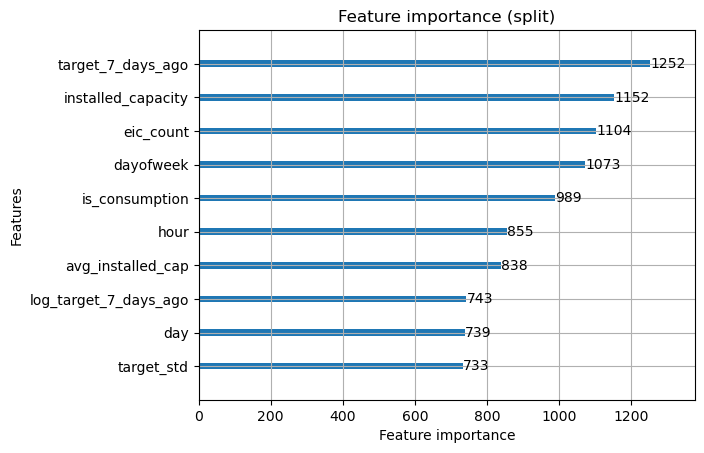

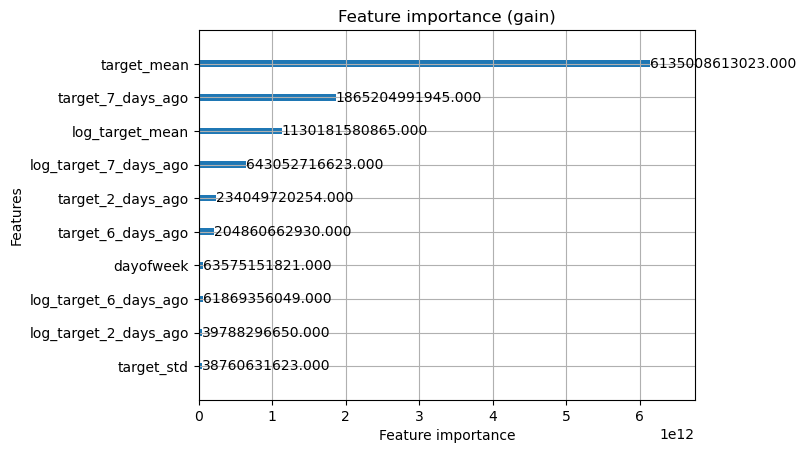

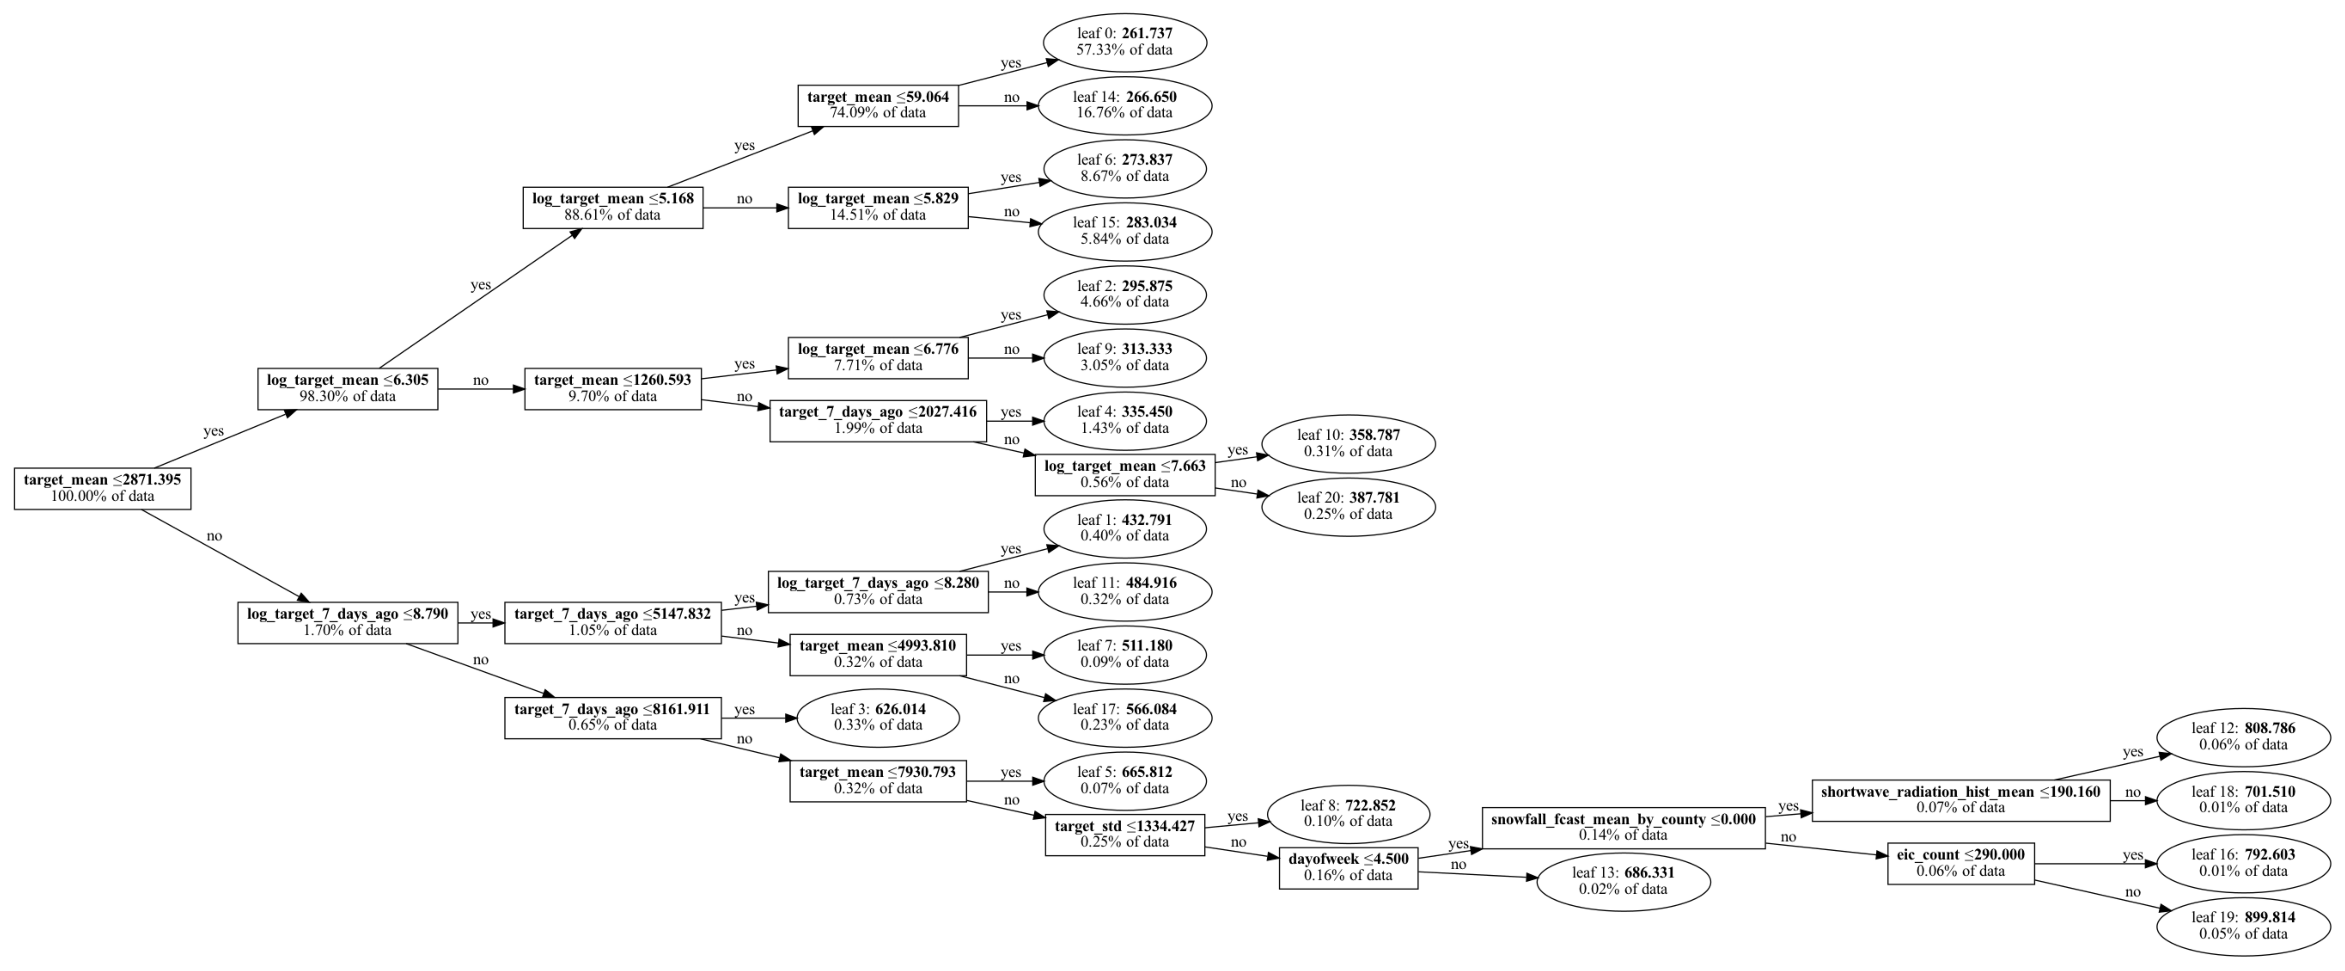

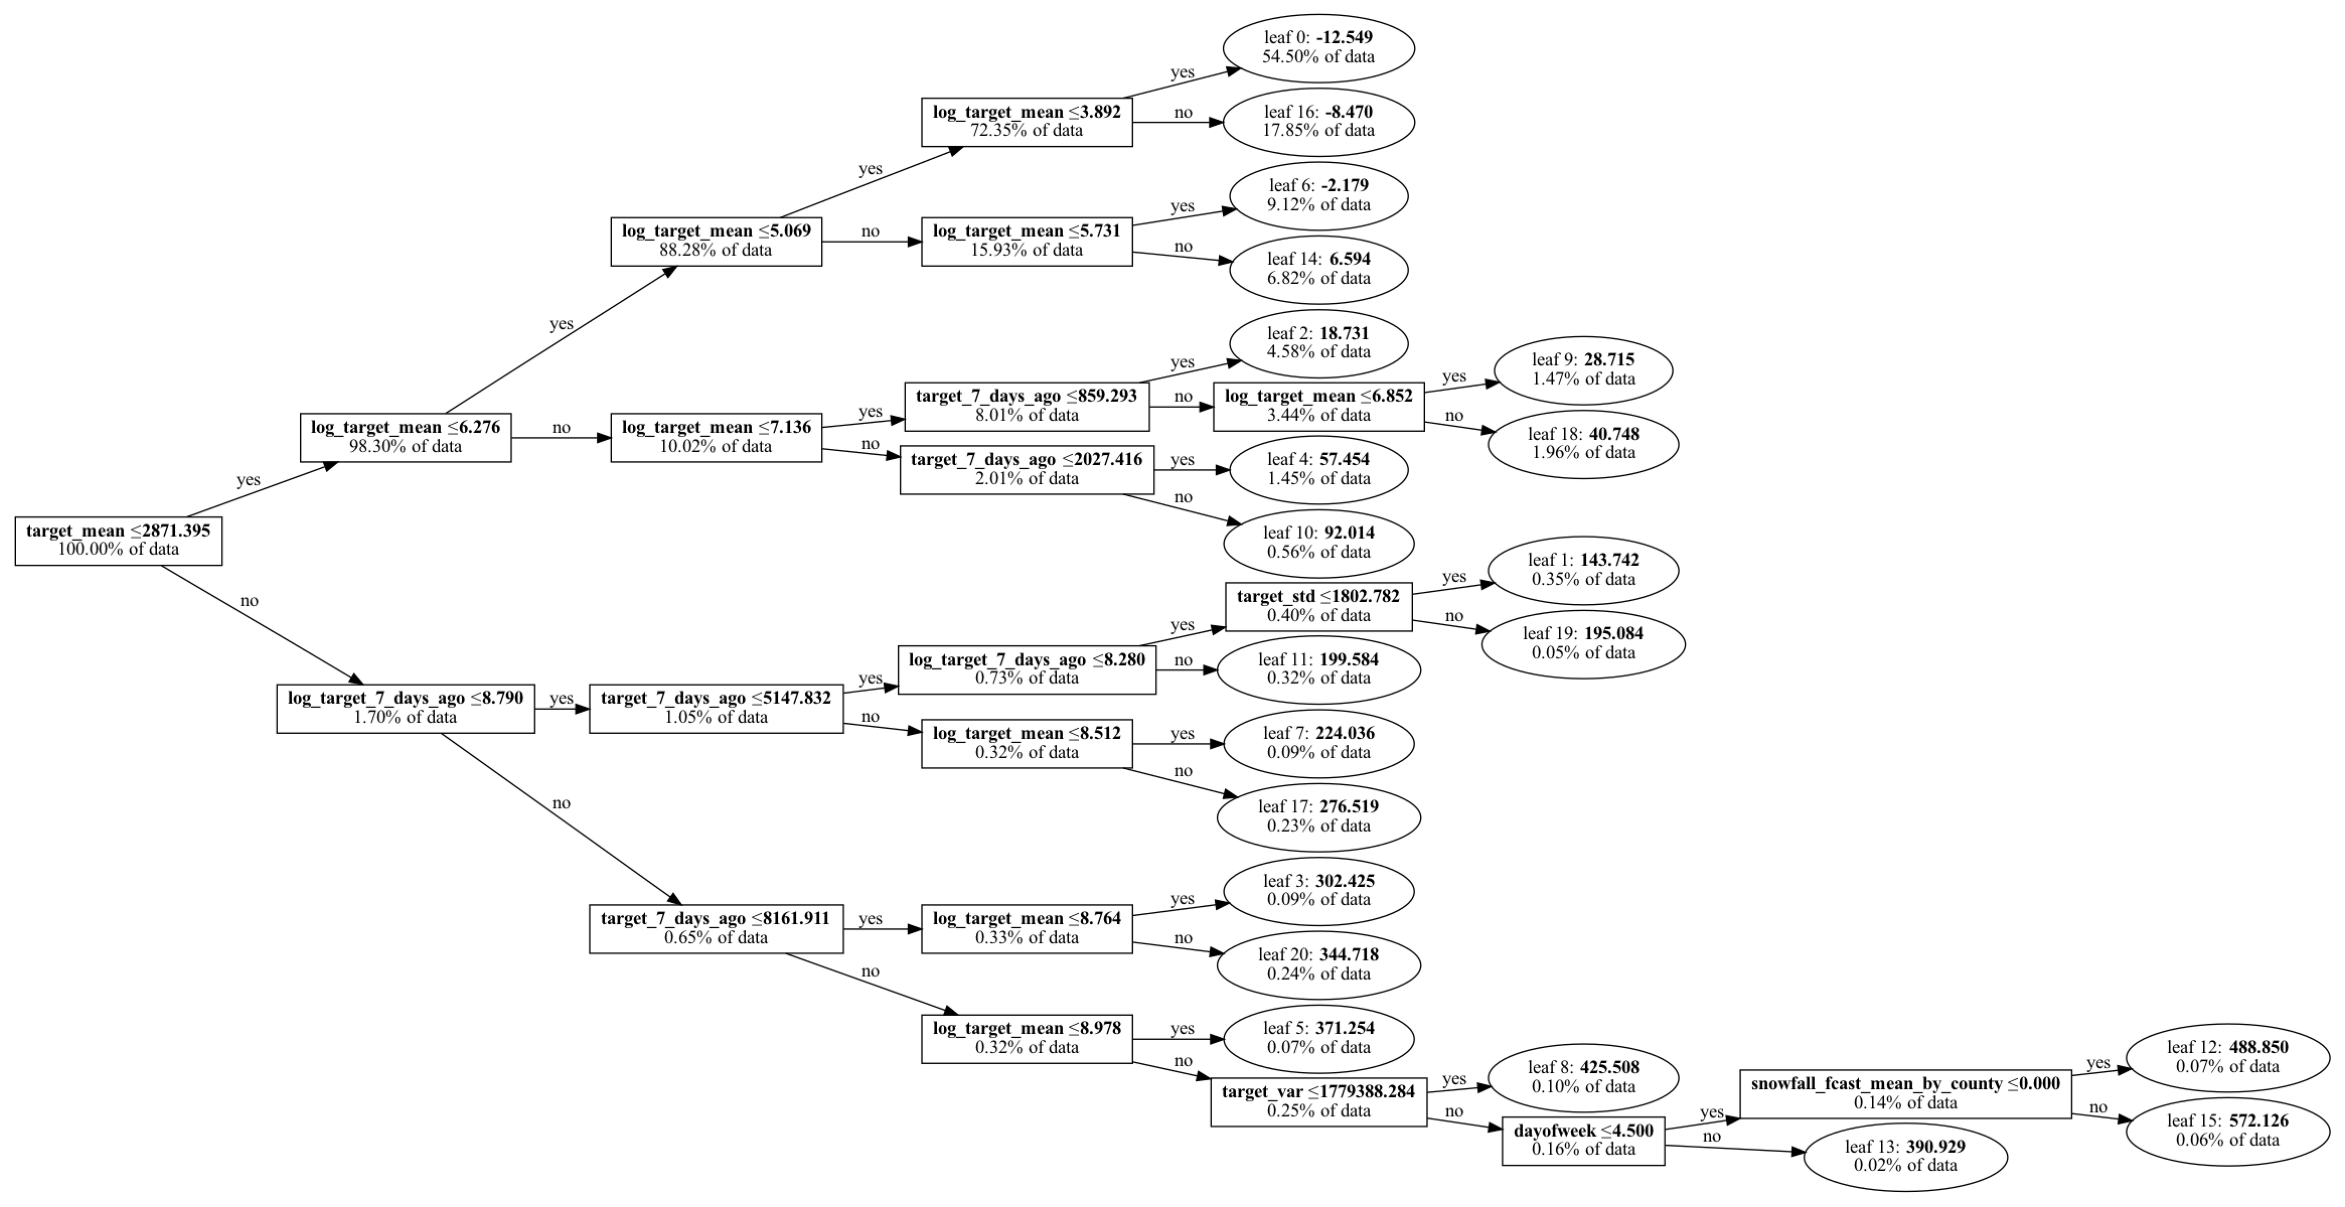

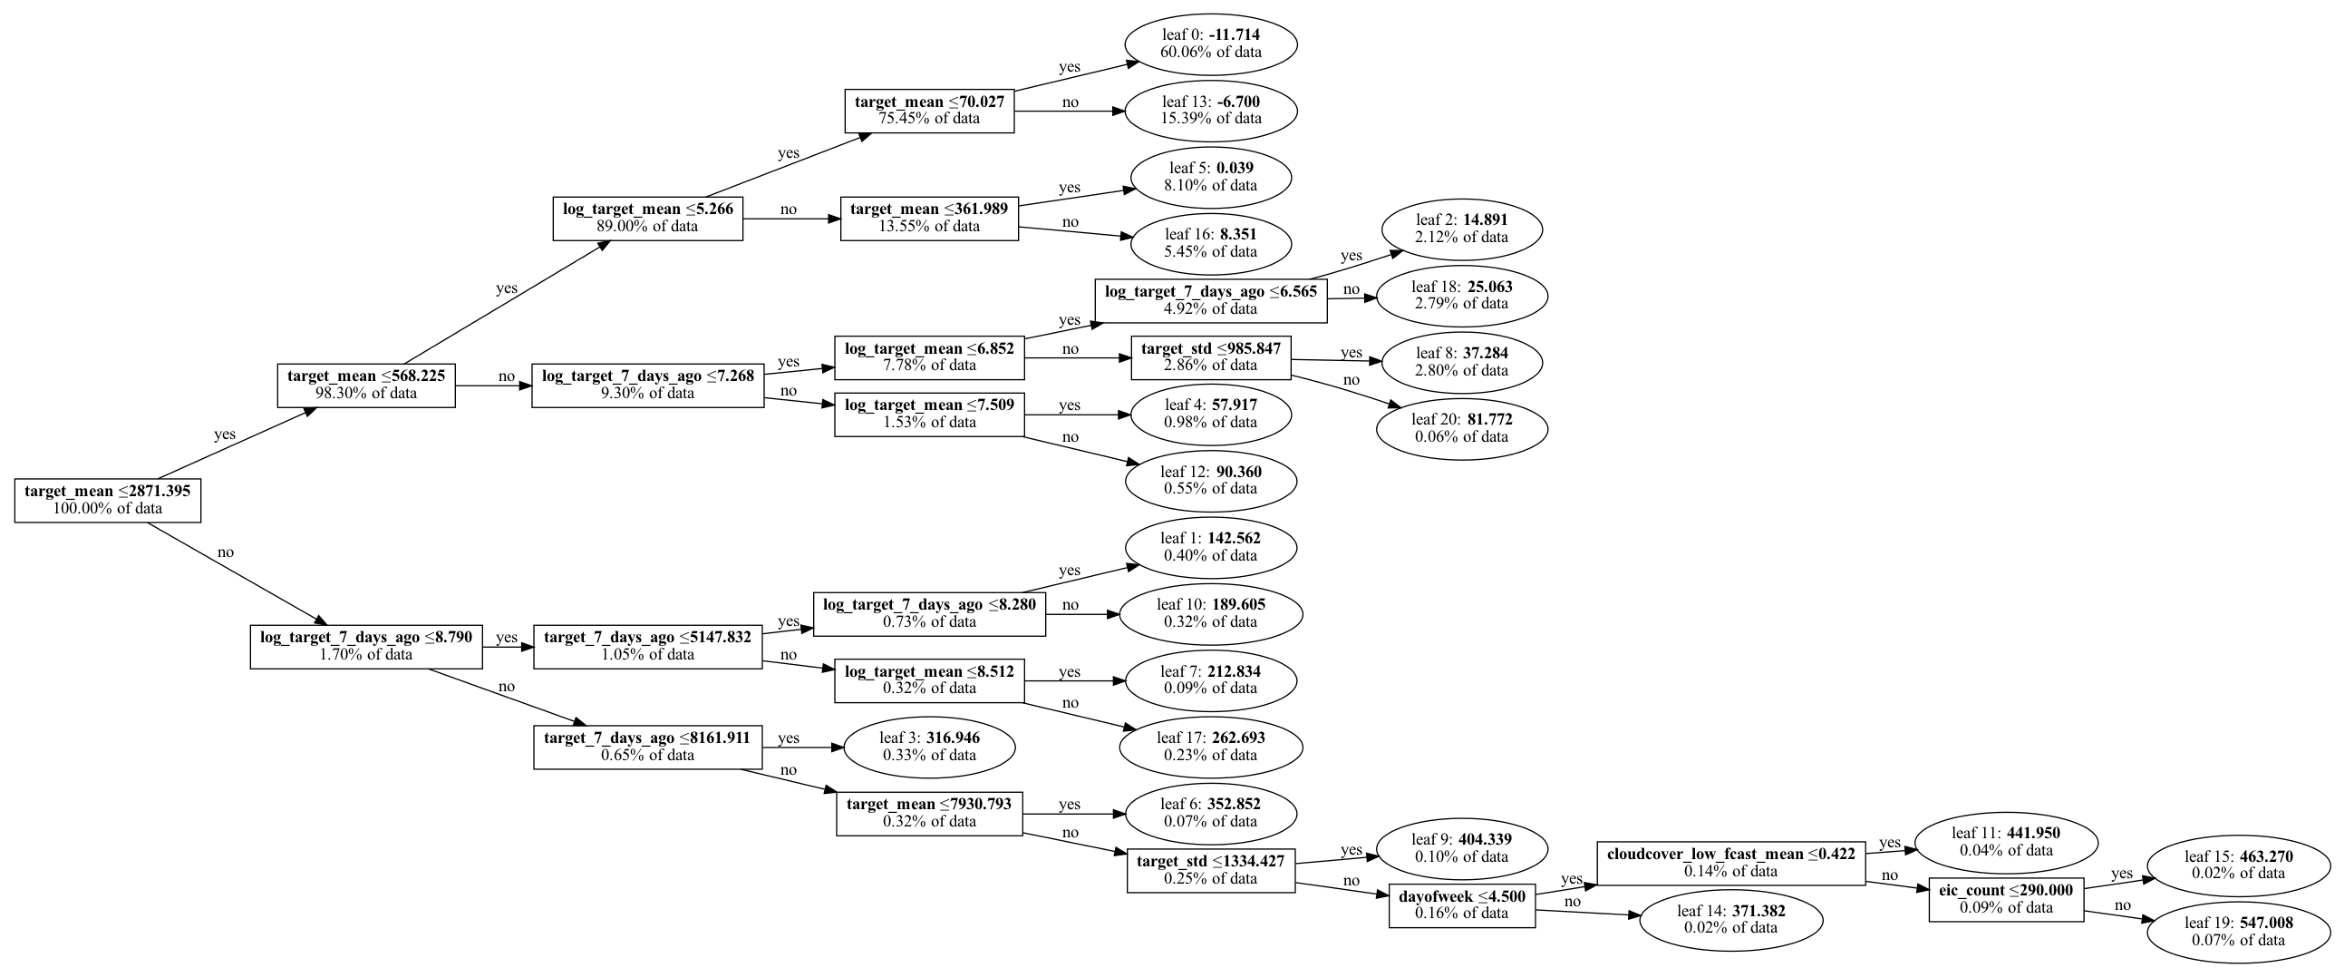

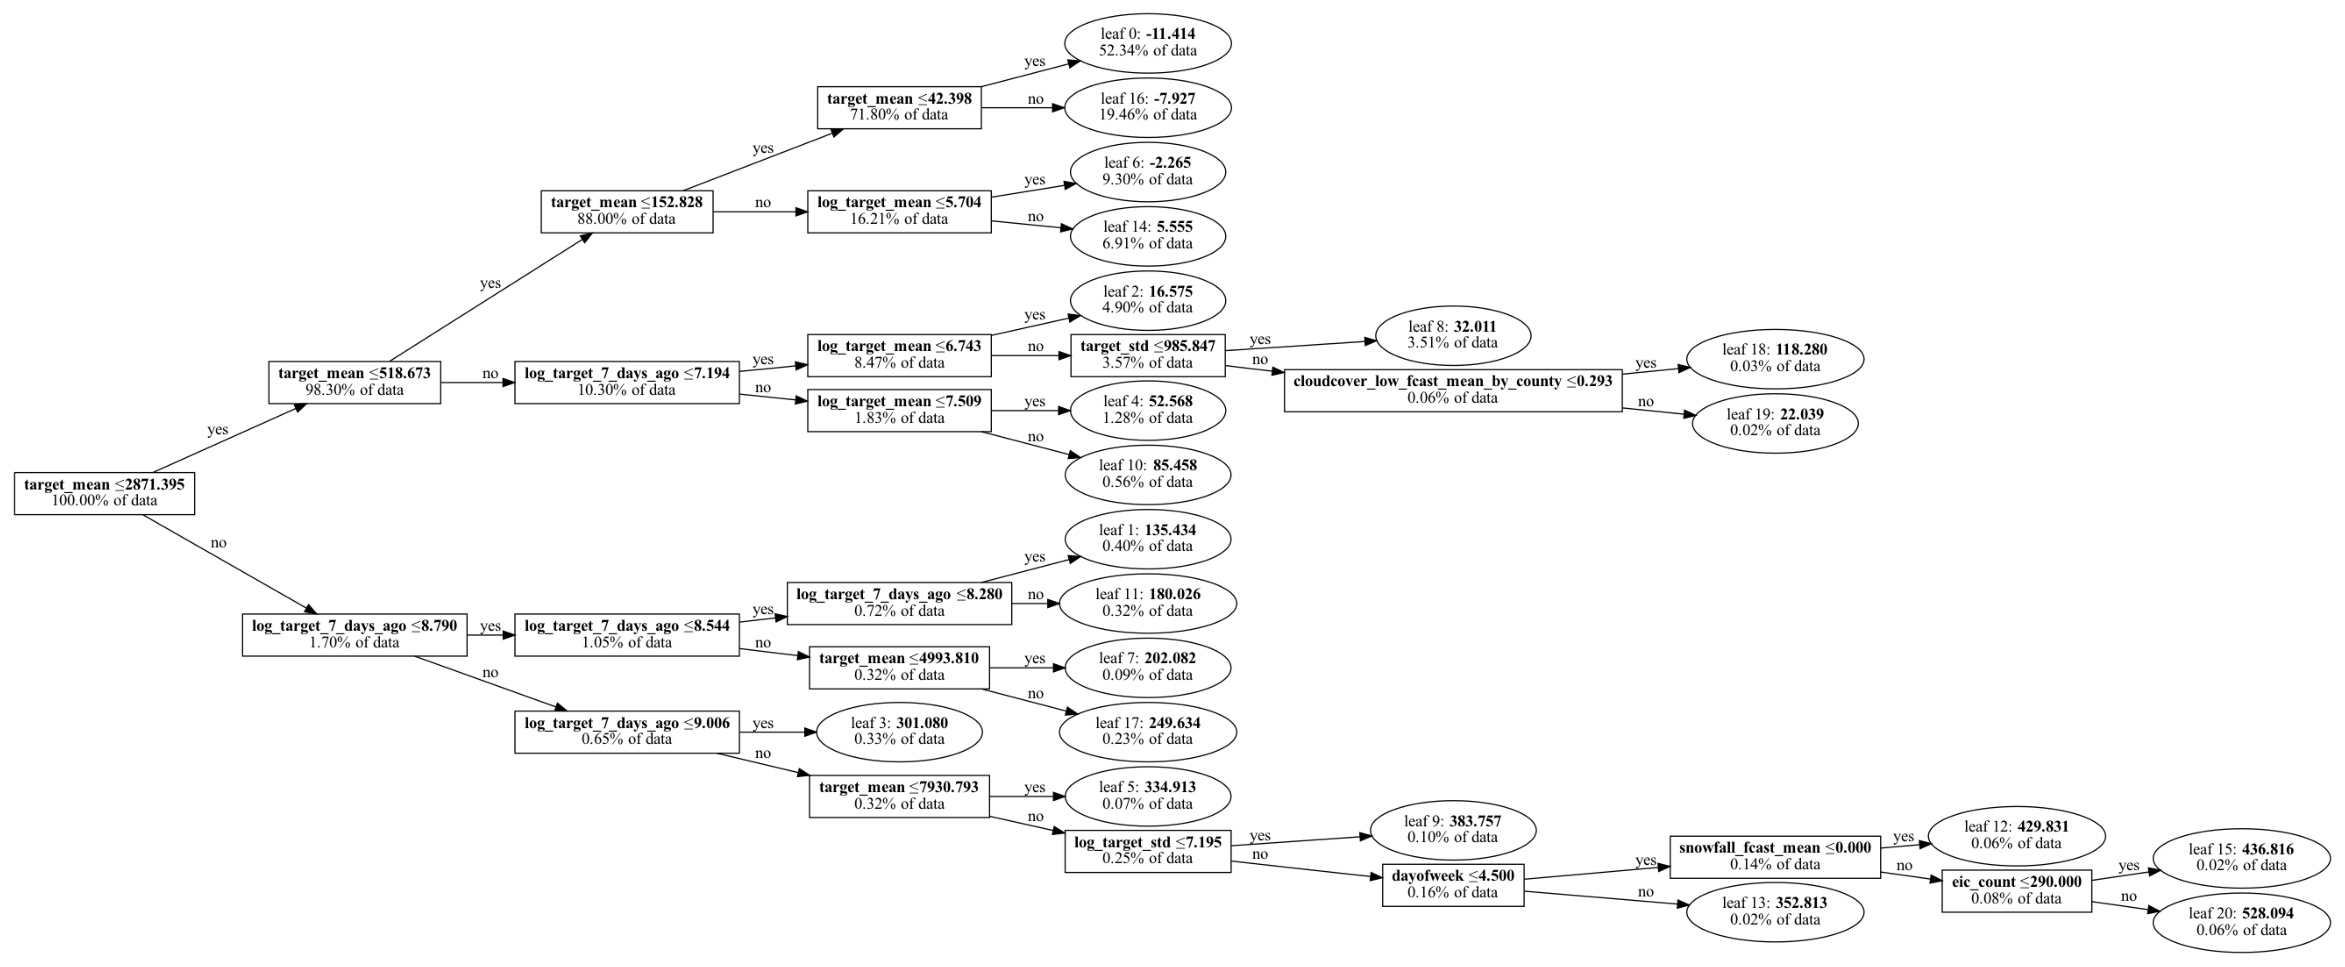

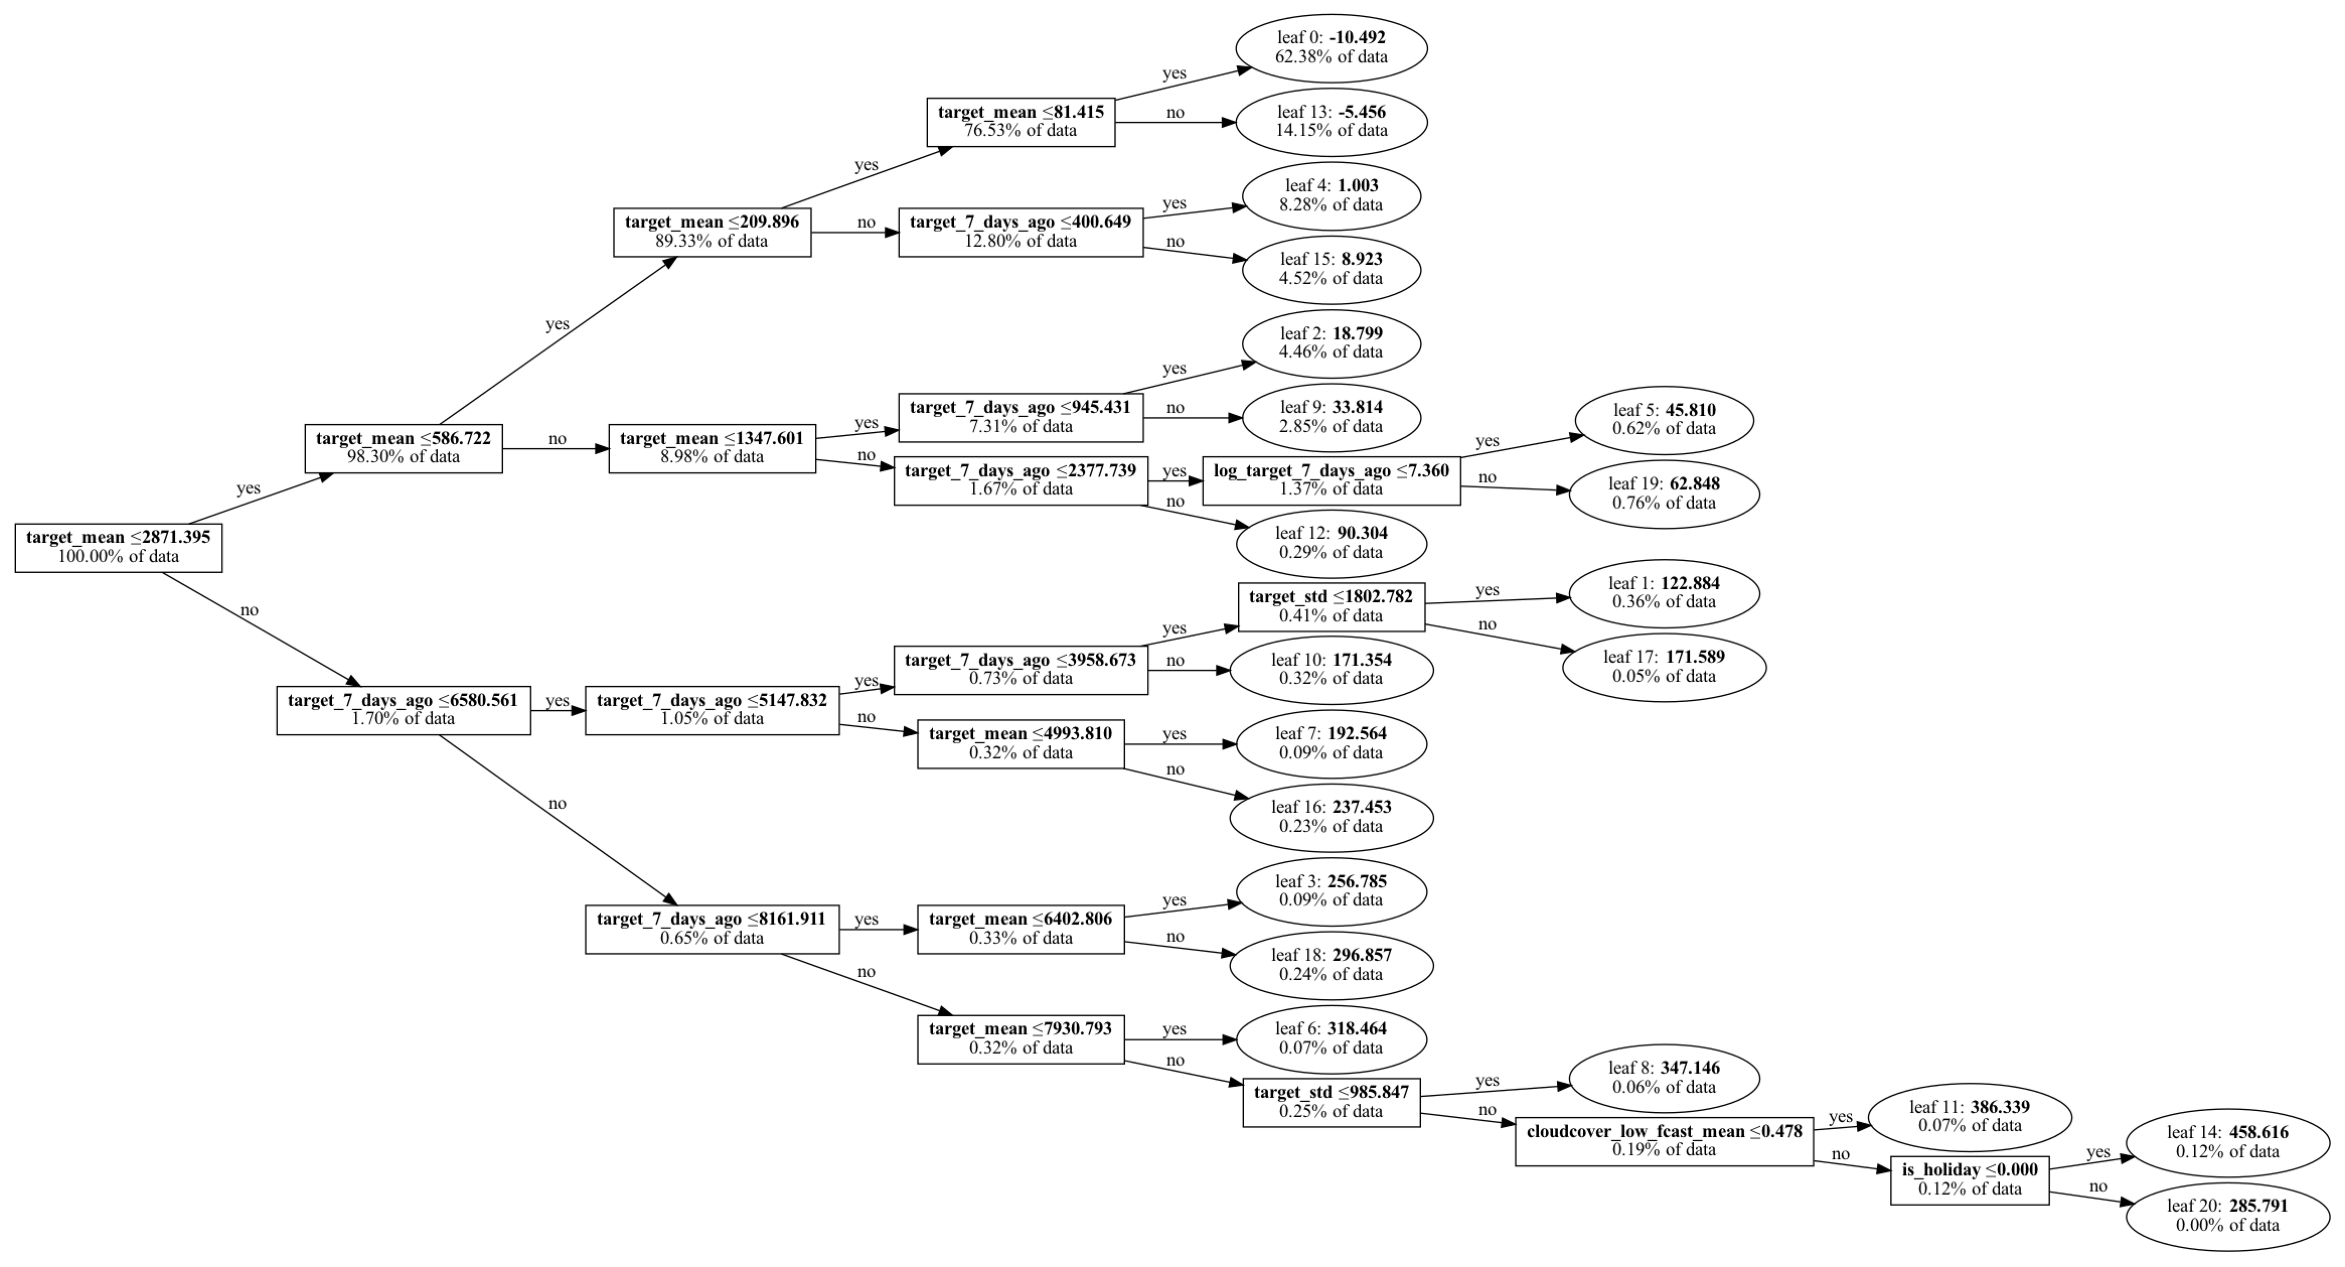

In [25]:

# Production Model

run = neptune.init_run(
    project="dextercorley19/Enefit",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlOThkMDNhZS1kNTQ4LTRjYmItOTE3ZC1jODI0NWVhNjRmOGYifQ==",
    name="train-cls", # Optional, but you should probably give it a name. Defaults to 'neptune-run-$run_id' if not specified. 
    tags=["lgbm-integration", "train", "Prod-model" "1500 rounds"], # Optional, list of strings. Defaults to empty list if not specified. 
) 

# Create Neptune callback
neptune_callback = NeptuneCallback(run=run) # Optional, but you should probably use it

# Prepare data
X2_train, X2_test, y2_train, y2_test = dask.compute(X2_train, X2_test, y2_train, y2_test)

prod_lgb_train = lgb.Dataset(X2_train, y2_train)
prod_lgb_eval = lgb.Dataset(X2_test, y2_test, reference=prod_lgb_train)

# Define parameters
prod_params = {
    "boosting_type": "gbdt",
    "objective": "tweedie",
    "metric": ["mean_absolute_error"],
    "verbose": -1,
    "num_leaves": 450,
    'min_data_in_leaf': 63,
    'min_data_per_groups': 59,
    "learning_rate": 0.01,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "max_depth": 11,
    "early_stopping_round": 100,
    'lambda_l1': 3.6277555139102864,
    'lambda_l2': 1.6591278779517808
}

# Train the model
prod_gbm = lgb.train(
    prod_params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, prod_lgb_eval],
    valid_names=["training", "validation"],
    callbacks=[neptune_callback],
)

y2_pred = prod_gbm.predict(X2_test)

# Log summary metadata to the same run under the "lgbm_summary" namespace
run["lgbm_summary"] = create_booster_summary(
    booster=prod_gbm,
    log_trees=True,
    list_trees=[0, 1, 2, 3, 4],
    log_confusion_matrix=False,
    y2_pred=y2_pred,
    y2_true=y2_test,
)

# When done logging, stop the run
run.stop()

In [29]:
train = lgb.Dataset(train, label='target')

params = {
        "objective": "tweedie",
        "metric": "mean_absolute_error",
        "verbose": -1,
        "num_iterations": 2000,
        "learning_rate": 0.05,
        "seed": 42,
        "boosting_type": "gbdt",
    }

from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb

model = lgb.train(force_row_wise=True, verbose = -1)
model = model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the accuracy
print(f"Mean Absolute Error: {mae}")

# Production model
prod_model = lgb.LGBMRegressor(force_row_wise=True, verbose = -1)
prod_model = prod_model.fit(X2_train, y2_train)
# Make predictions
y2_pred = model.predict(X2_test)

# Calculate mean absolute error
prod_mae = mean_absolute_error(y2_test, y2_pred)

# Print the accuracy
print(f"Production Mean Absolute Error: {prod_mae}")



[I 2024-01-08 22:47:01,886] A new study created in memory with name: no-name-bcf943d1-1521-416b-9094-a6cd46b148aa
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s][W 2024-01-08 22:47:01,907] Trial 0 failed with parameters: {'feature_fraction': 0.6} because of the following error: TypeError("cv() only accepts Dataset object, train_set has type 'DataFrame'.").
Traceback (most recent call last):
  File "/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py", line 317, in __call__
    cv_results = lgb.cv(self.lgbm_params, train_set, **self.lgbm_kwargs)
  File "/Users/dcmac14/miniconda3/envs/tensorflow/lib/python3.10/site-packages/lightgbm/engine.py", line 668, in cv
    raise TypeError(f"cv() only accepts Dataset object, train_set has type '{t

TypeError: cv() only accepts Dataset object, train_set has type 'DataFrame'.

In [16]:
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb

model = lgb.LGBMRegressor(force_row_wise=True, verbose = -1)
model = model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the accuracy
print(f"Mean Absolute Error: {mae}")

# Production model
prod_model = lgb.LGBMRegressor(force_row_wise=True, verbose = -1)
prod_model = prod_model.fit(X2_train, y2_train)
# Make predictions
y2_pred = model.predict(X2_test)

# Calculate mean absolute error
prod_mae = mean_absolute_error(y2_test, y2_pred)

# Print the accuracy
print(f"Production Mean Absolute Error: {prod_mae}")


Mean Absolute Error: 41.587402234197306
Production Mean Absolute Error: 27.78613418387399


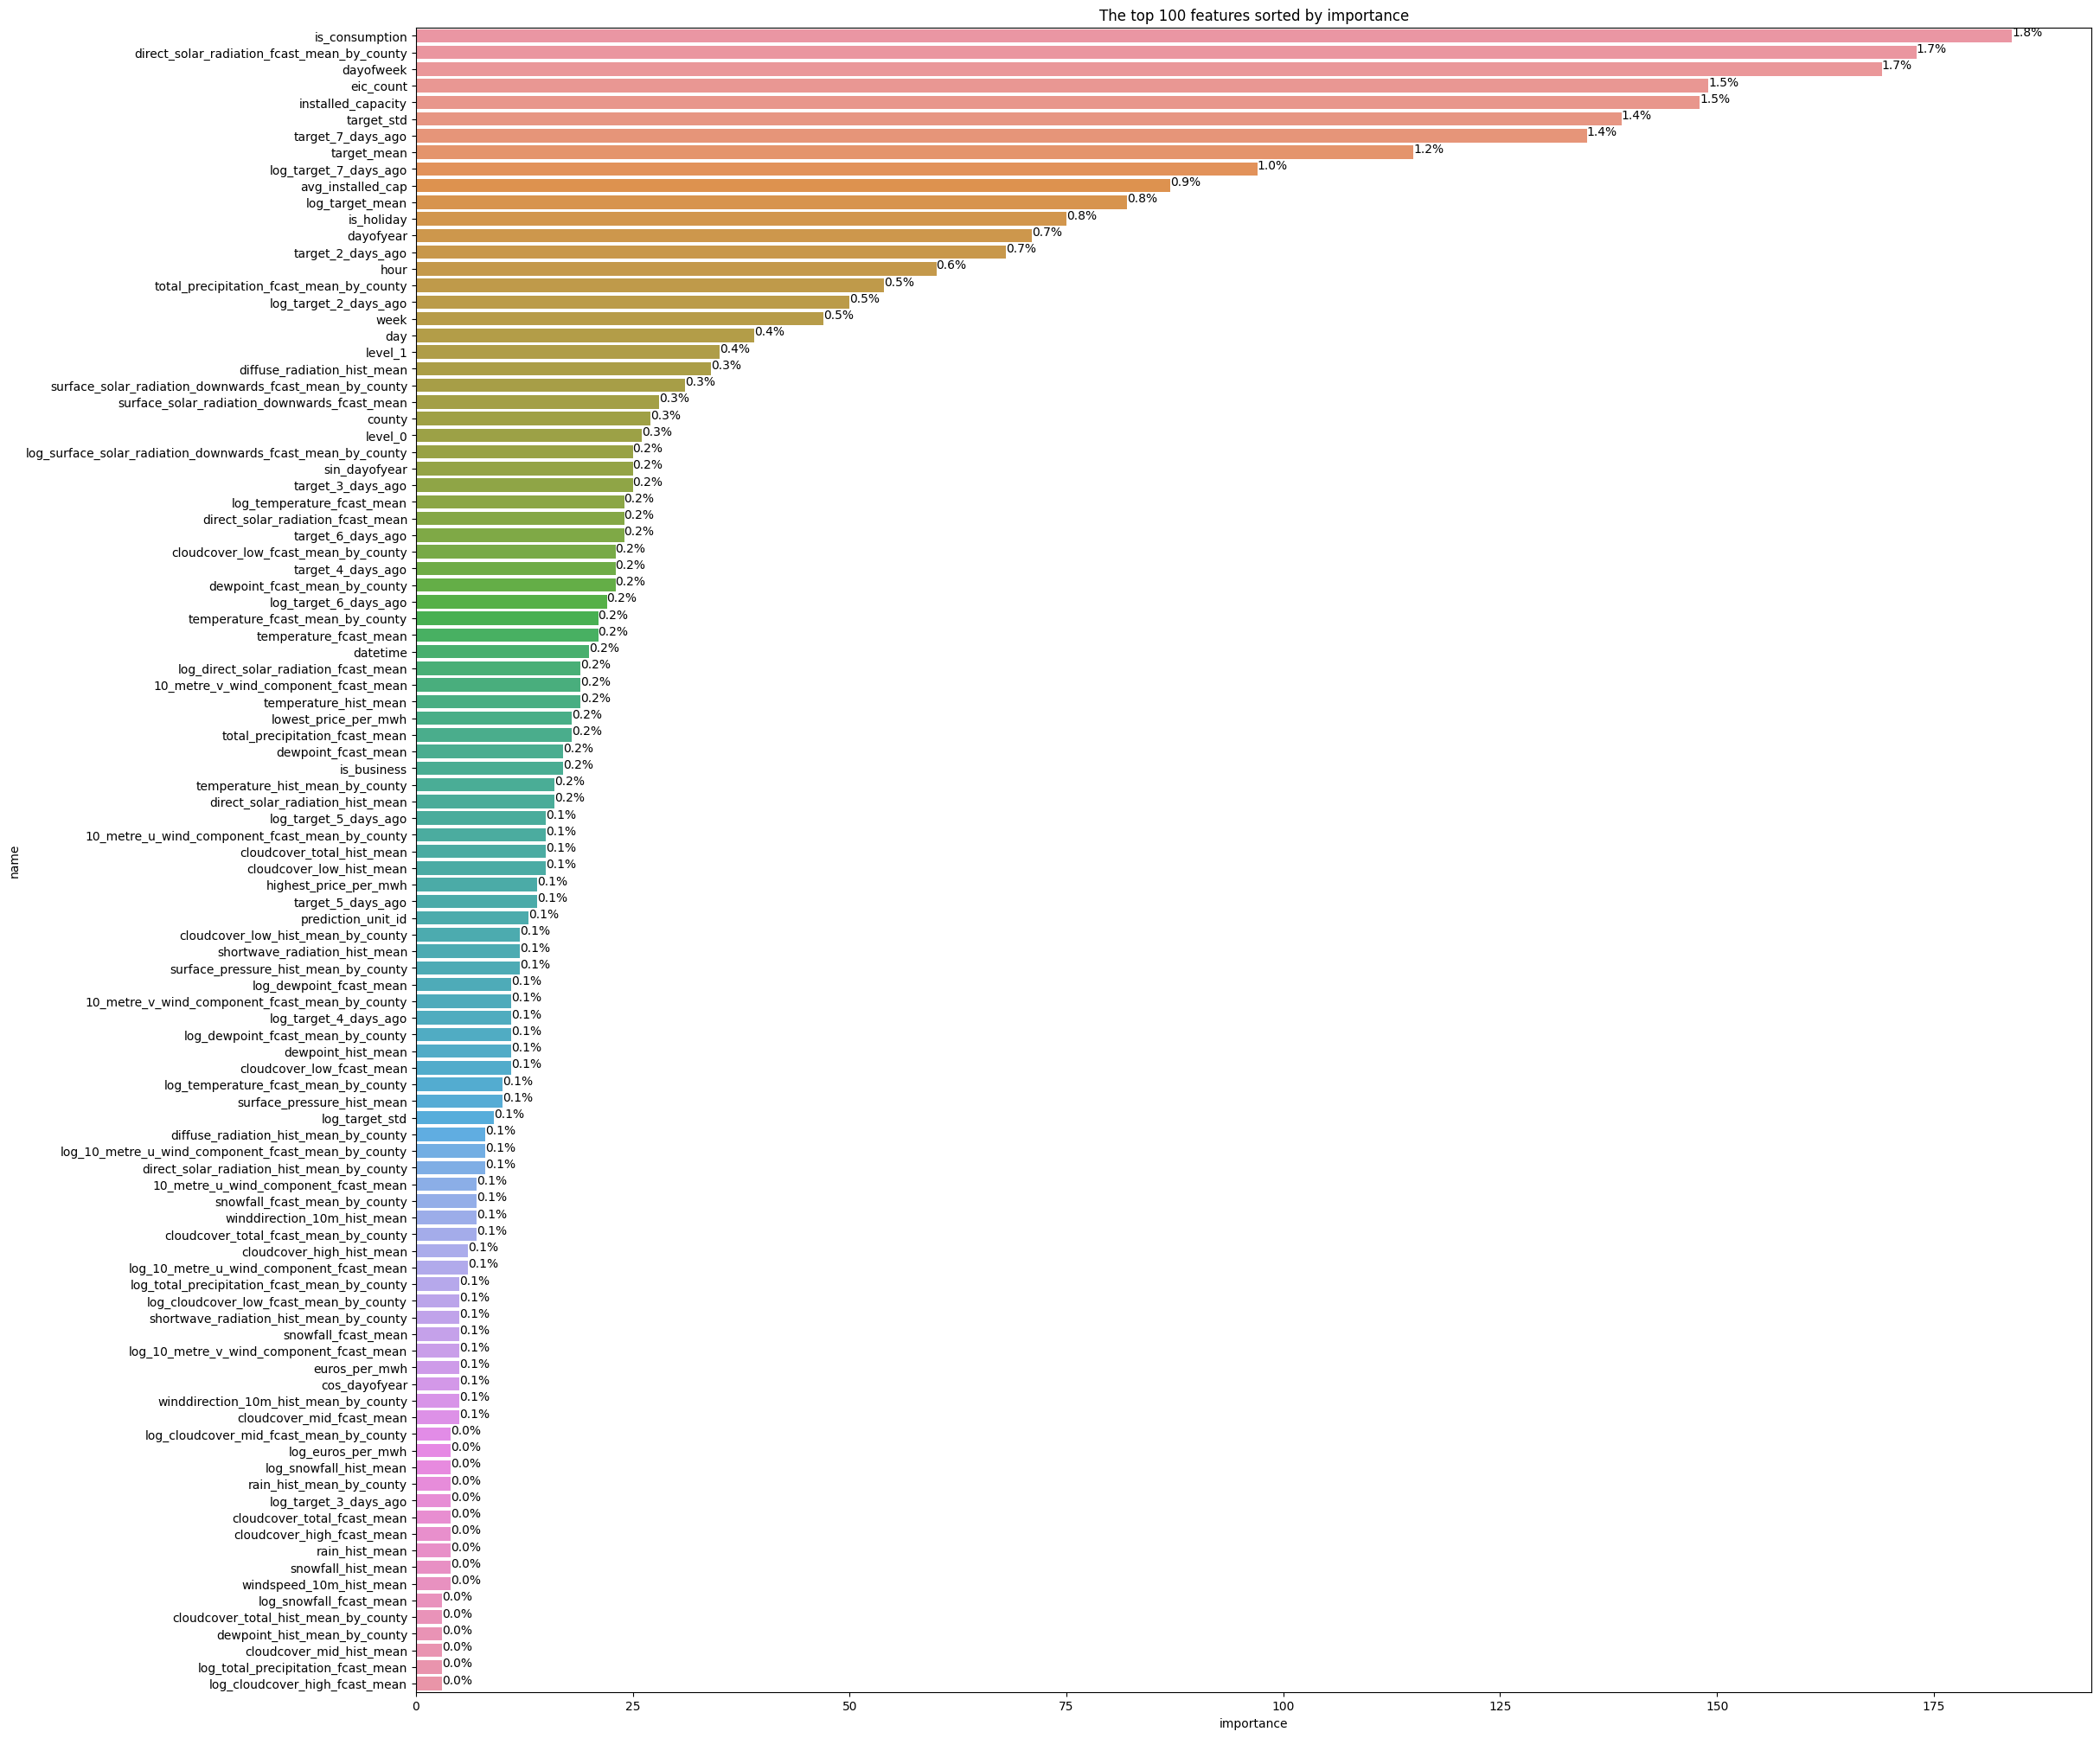

In [19]:
TOP = 100
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': model.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

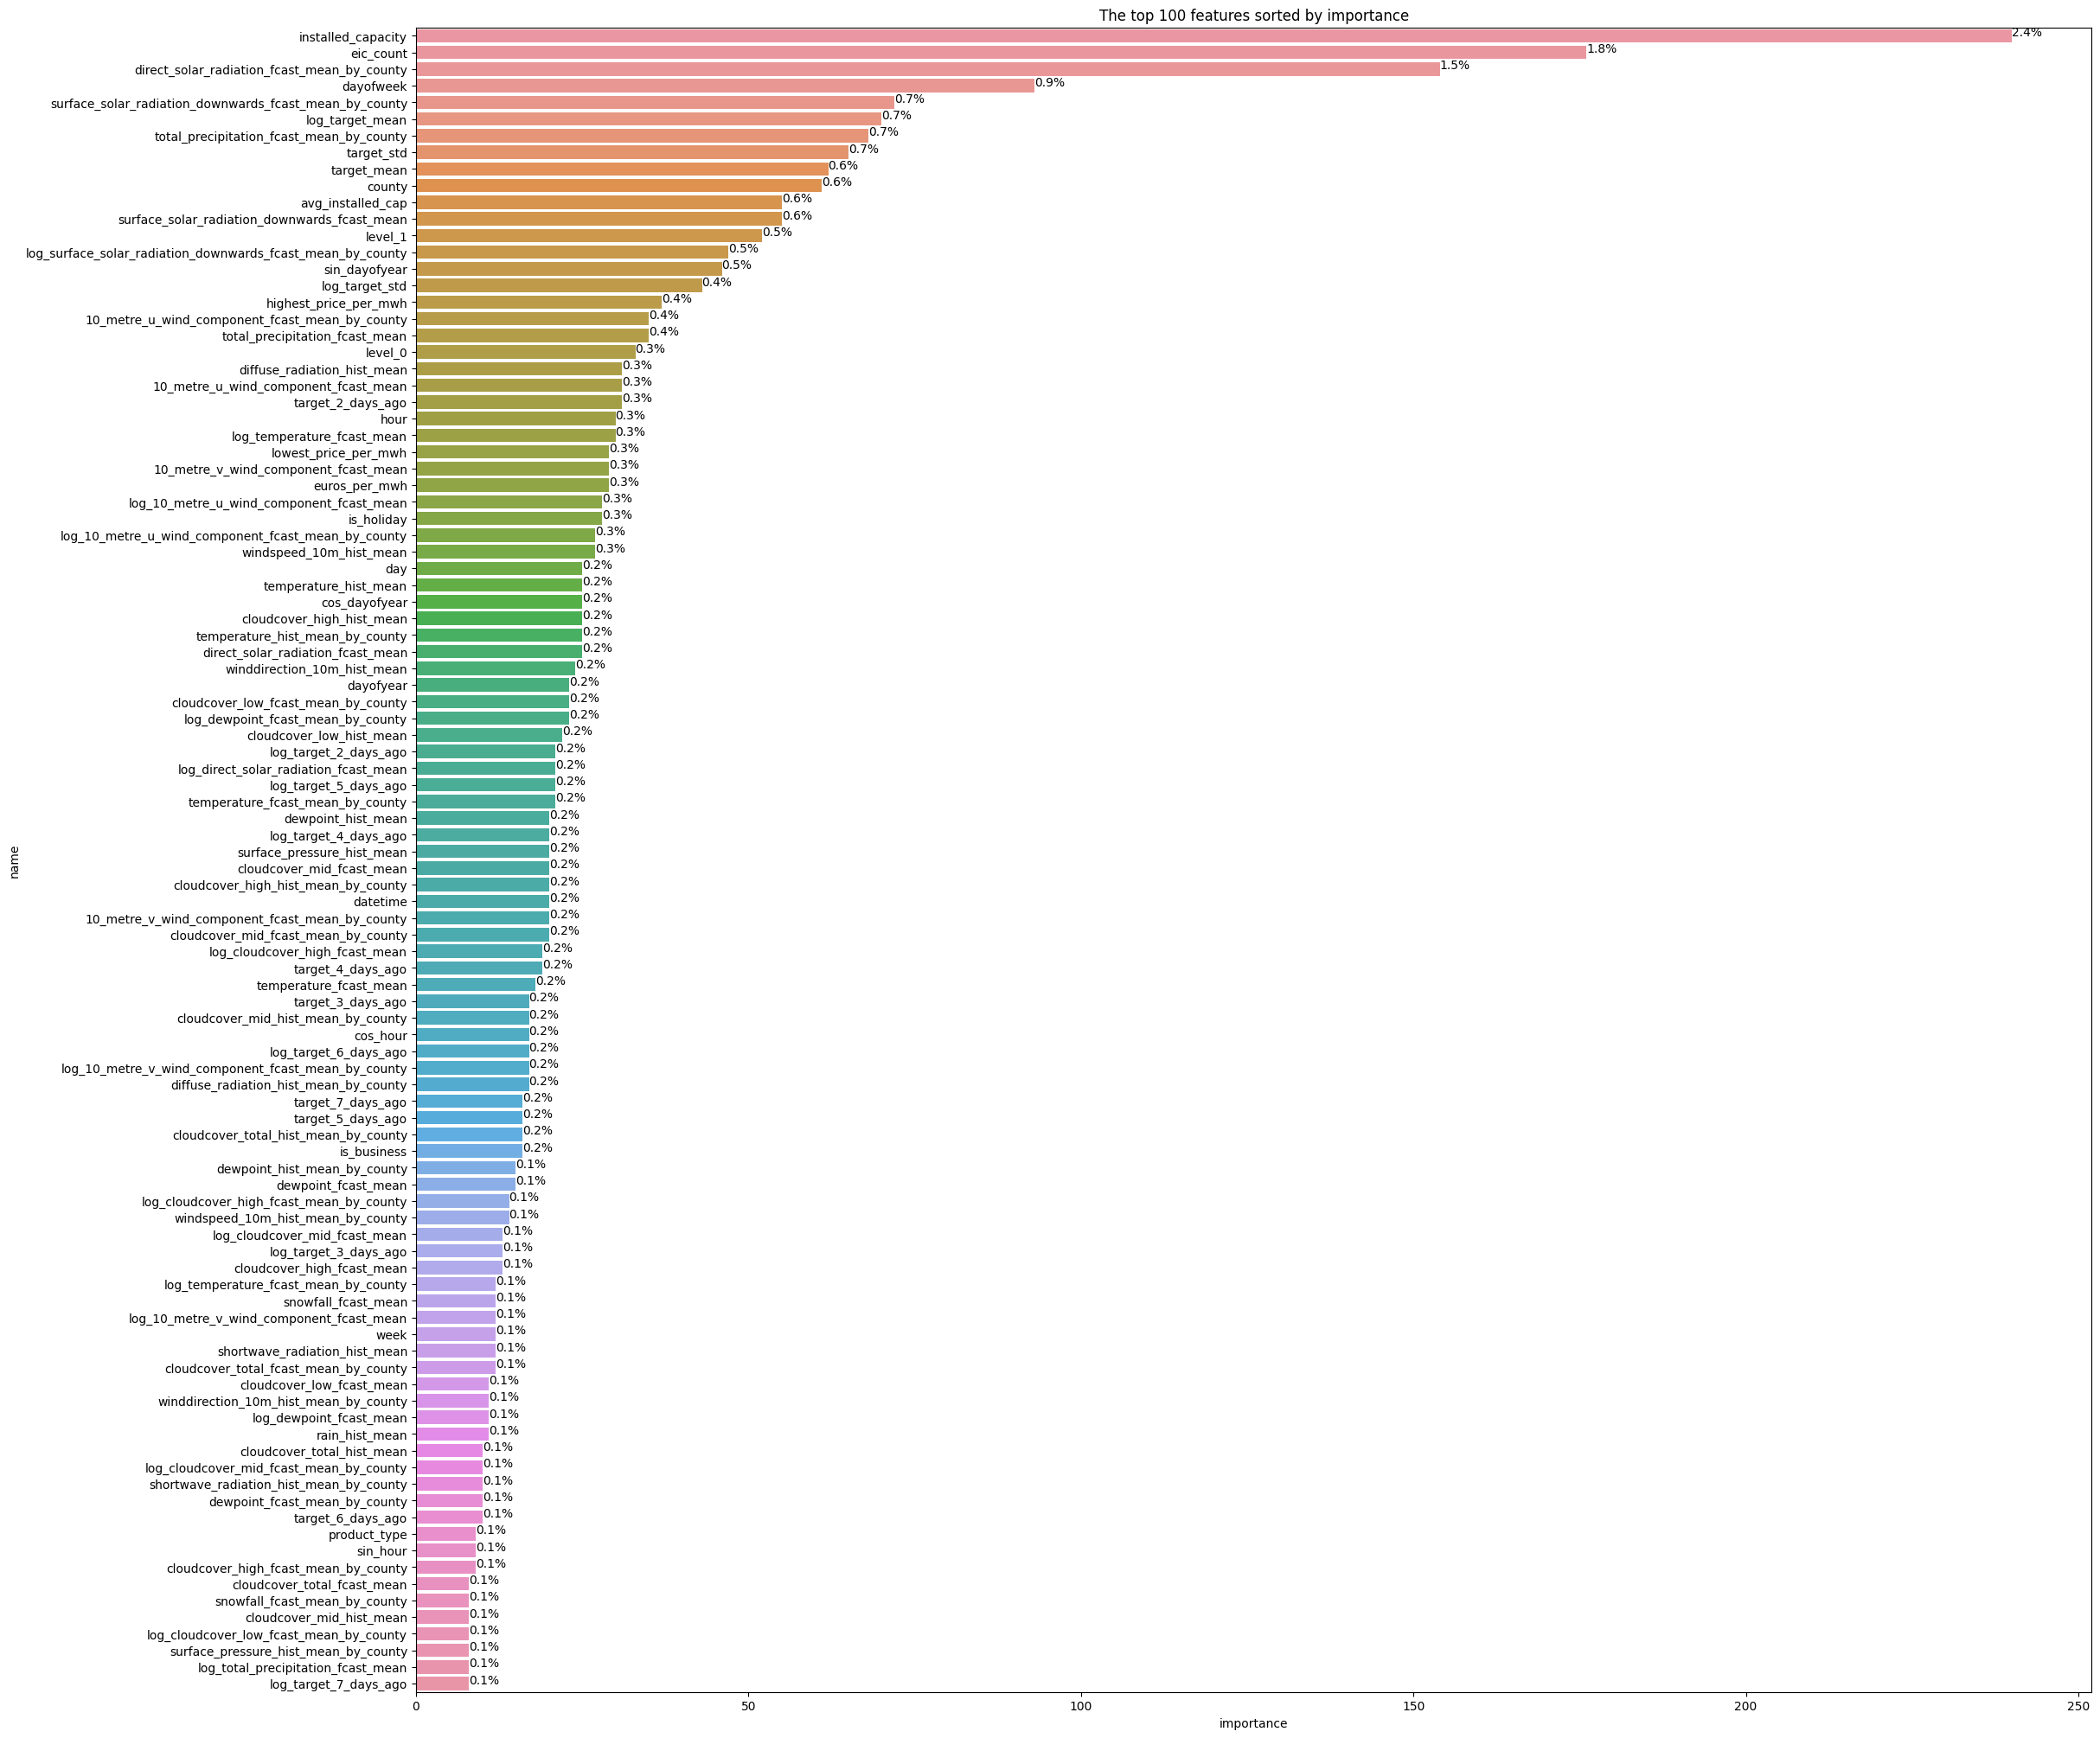

In [21]:
TOP = 100
importance_data = pd.DataFrame({'name': train.drop('target', axis= 1).columns
, 'importance': prod_model.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(25,25))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 0.01*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

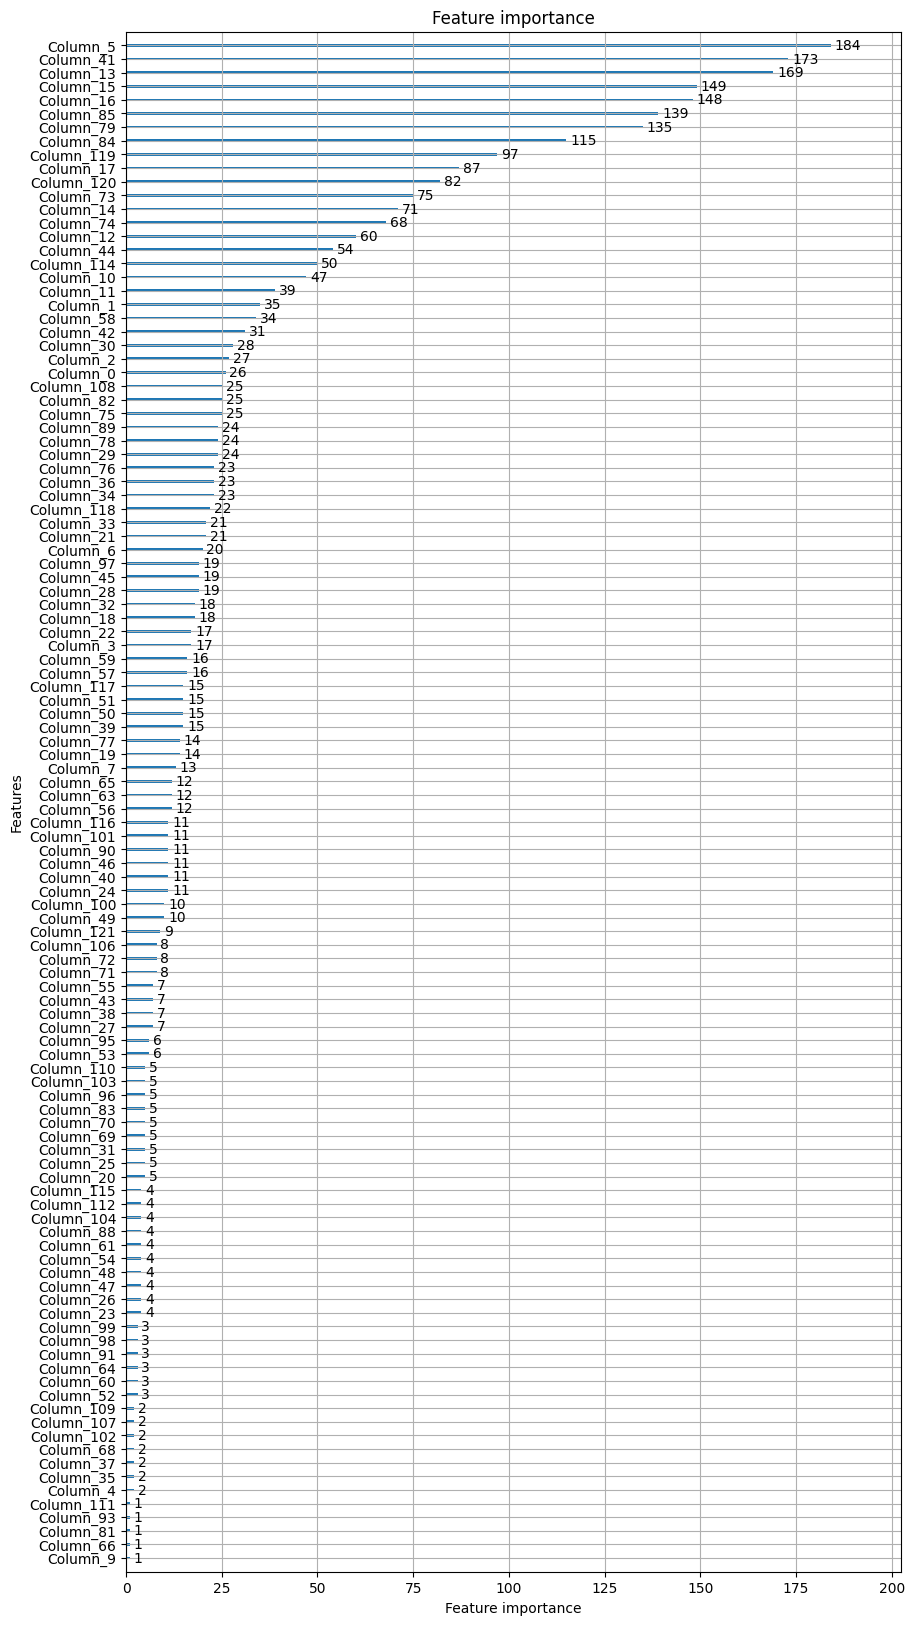

In [57]:
ax = lgb.plot_importance(model)
fig = plt.gcf()
fig.set_size_inches(10, 20)
ax

## Submission

In [58]:
def TestPreprocessing(test, client_df, fw_df, electricity_df, gas_df, locations, hw_df):
    '''Test data preprocessing'''

    # Converting to datetime & date feature engineering
    test = test.rename(columns={'prediction_datetime' : 'datetime'})

    test['datetime'] = pd.to_datetime(test['datetime'], utc=True)

    test['year'] = test['datetime'].dt.year
    test['quarter'] = test['datetime'].dt.quarter
    test['month'] = test['datetime'].dt.month
    test['week'] = test['datetime'].dt.isocalendar().week
    test['day'] = test['datetime'].dt.day
    test['hour'] = test['datetime'].dt.hour
    test['dayofweek'] = test['datetime'].dt.dayofweek
    test['dayofyear'] = test['datetime'].dt.dayofyear

    test['week'] = test['week'].astype('int64')

    test["jan_flag"] = (test["month"] == 1).astype(int)

    # Client data processing
    # Subtracting 2 from data_block_id. Data is two steps ahead
    client_df['data_block_id'] -= 2
    
    # Average installed capacity. (installed_capacity / eic_count)
    client_df['avg_installed_cap'] = client_df['installed_capacity'] / client_df['eic_count']

    
    # Electricity data processing
    # Renaming (forecast_date) to (datetime) for merging with the test data later
    electricity_df = electricity_df.rename(columns= {'forecast_date' : 'datetime'})
    
    # Converting (datetime) column to datetime
    electricity_df['datetime'] = pd.to_datetime(electricity_df['datetime'], utc= True)
    
    electricity_df['hour'] = electricity_df['datetime'].dt.hour
    
    # Locations data processing
    # Drop
    locations = locations.drop('Unnamed: 0', axis= 1) 
        

    # Forecast Weather 
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    
    # 1.
    fw_df[['latitude', 'longitude']] = fw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    fw_df = fw_df.merge(locations, how='left', on=['latitude', 'longitude'])
    
    # 3.
    fw_df.dropna(axis=0, inplace=True)
    
    # 4.
    fw_df['county'] = fw_df['county'].astype('int64')
    
    # 5.
    fw_df.drop(['origin_datetime', 'latitude', 'longitude', 'hours_ahead',
               'data_block_id'], axis=1, inplace=True)
    
    # 6.
    fw_df.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
    fw_df['datetime'] = pd.to_datetime(fw_df['datetime'], utc=True)
    
    # 7.
    fw_df_mean = fw_df.groupby([fw_df['datetime']
                                .dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1)
                                                                           .columns)].mean().reset_index()
    fw_df_mean['datetime'] = pd.to_datetime(fw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    # 8. 
    fw_df_county = fw_df.groupby(['county', fw_df['datetime'].dt.to_period('h')])[list(fw_df.drop(['county', 'datetime'], axis=1).columns)].mean().reset_index()
    fw_df_county['datetime'] = pd.to_datetime(fw_df_county['datetime'].dt.to_timestamp(), utc=True)

    
    # Historical weather df processing
    # 1. Rounding lat & lon to 1 decimal place
    # 2. Merge counties data from locations DF to lat & lon in forecast weather df
    # 3. Drop null rows
    # 4. Convert county col to int dtype
    # 5. Drop un-necessary columns
    # 6. Rename date column to 'datetime' and convert to datetime dtype
    # 7. New df with mean weather values per hour. Convert datetime back to normal datetime format in new df.
    # 8. New df with mean values per hour grouped also by county. Convert datetime col back to datetime.
    # 9. Merge data_block_id back to new county df
   
    # 1.
    hw_df[['latitude', 'longitude']] = hw_df[['latitude', 'longitude']].astype(float).round(1)
    
    # 2.
    hw_df = hw_df.merge(locations, how='left', on=['longitude', 'latitude'])
    
    # 3.
    hw_df.dropna(axis=0, inplace=True)
    
    # 4.
    hw_df['county'] = hw_df['county'].astype('int64')
    
    # 5.
    hw_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
    
    # 6.
    hw_df['datetime'] = pd.to_datetime(hw_df['datetime'], utc=True)
    
    # 7.
    hw_df_mean = hw_df.groupby([hw_df['datetime']
                                .dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1)
                                                                           .columns)].mean().reset_index()
    hw_df_mean['datetime'] = pd.to_datetime(hw_df_mean['datetime'].dt.to_timestamp(), utc=True)
    
    hw_df_mean = hw_df_mean.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    
    # 8. 
    hw_df_county = hw_df.groupby(['county', hw_df['datetime'].dt.to_period('h')])[list(hw_df.drop(['county', 'datetime', 'data_block_id'], axis=1).columns)].mean().reset_index()
    hw_df_county['datetime'] = pd.to_datetime(hw_df_county['datetime'].dt.to_timestamp(), utc=True)
    hw_df_county = hw_df_county.merge(hw_df[['datetime', 'data_block_id']], how='left', on='datetime')
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_county.reset_index()
    
    # Merge the data into test set
    # 1. Merge client 
    # 2. Merge gas
    # 3. Merge electricity
    # 4. Merge forecast weather
    # 5. Merge forecast weather by county
    # 6. Add hour col to hist weather and hist county. Drop dups and datetime col
    # 7. Merge hist weather menas
    # 8. Merge hist weather means by county
    # 9. Fill null values with forward and backward method
    # 10. Drop un-necessary cols...?

    
    # 1
    test = test.merge(client_df.drop(columns = ['date']), how='left', on = ['data_block_id', 'county', 'is_business', 'product_type'])
    
    # 2
    test = test.merge(gas_df[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')
    
    # 3
    test = test.merge(electricity_df[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour','data_block_id'])
    
    # 4 
    test = test.merge(fw_df_mean, how='left', on='datetime')
    
    # 5 
    test = test.merge(fw_df_county, how='left', on=['datetime', 'county'], suffixes = ('_fcast_mean', '_fcast_mean_by_county'))
    
    # 6
    hw_df_mean['hour'] = hw_df_mean['datetime'].dt.hour
    hw_df_county['hour'] = hw_df_county['datetime'].dt.hour
    
    hw_df_mean.drop_duplicates(inplace=True)
    hw_df_county.drop_duplicates(inplace=True)
    hw_df_mean.drop('datetime', axis=1, inplace=True)
    hw_df_county.drop('datetime', axis=1, inplace=True)

    # 7
    test = test.merge(hw_df_mean, how='left', on=['data_block_id', 'hour'])
    
    # 8 
    test = test.merge(hw_df_county, how='left', on=['data_block_id', 'county', 'hour'], suffixes= ('_hist_mean', '_hist_mean_by_county'))
    
    # 9
    test = test.groupby(['year', 'day', 'hour'], as_index=False).apply(lambda x: x.ffill().bfill()).reset_index()
    
    # 10
    test.drop(['row_id', 'data_block_id'], axis = 1, inplace = True)
    
    return test

In [59]:
def create_revealed_targets_test(data, previous_revealed_targets, N_lags):
    '''🎯 Create new test data based on previous_revealed_targets and N_day_lags 🎯 ''' 
    for count, revealed_targets in enumerate(previous_revealed_targets) :
        day_lag = count + 2
        
        # Get hour
        revealed_targets['hour'] = pd.to_datetime(revealed_targets['datetime'], utc= True).dt.hour
        
        # Select columns and rename target
        revealed_targets = revealed_targets[['hour', 'prediction_unit_id', 'is_consumption', 'target']]
        revealed_targets = revealed_targets.rename(columns = {"target" : f"target_{day_lag}_days_ago"})
        
        
        # Add past revealed targets
        data = pd.merge(data,
                        revealed_targets,
                        how = 'left',
                        on = ['hour', 'prediction_unit_id', 'is_consumption'],
                       )
        
    # If revealed_target_columns not available, replace by nan
    all_revealed_columns = [f"target_{day_lag}_days_ago" for day_lag in range(2, N_lags+1)]
    missing_columns = list(set(all_revealed_columns) - set(data.columns))
    data[missing_columns] = np.nan 
    
    return data

In [61]:
env = enefit.make_env()
iter_test = env.iter_test()
previous_revealed_targets = []
for (test, revealed_targets, client_test, historical_weather_test,
     forecast_weather_test, electricity_test, gas_test,sample_prediction) in iter_test:
    
    # Initiate column data_block_id with default value to merge the data on
    id_column = 'data_block_id' 
    
    test[id_column] = 0
    gas_test[id_column] = 0
    electricity_test[id_column] = 0
    historical_weather_test[id_column] = 0
    forecast_weather_test[id_column] = 0
    client_test[id_column] = 0
    revealed_targets[id_column] = 0

    data_test = TestPreprocessing(test, client_test, forecast_weather_test, electricity_test, gas_test, locations, historical_weather_test)
    data_test = is_holiday(data_test)
    
    # Drop year column as its no longer needed
    data_test.drop(['year'], axis=1, inplace=True)
    data_test['datetime']= pd.to_datetime(data_test['datetime'], utc= True).astype('int64')
    
    # Store revealed_targets
    previous_revealed_targets.insert(0, revealed_targets)
    if len(previous_revealed_targets) == N_lags:
        previous_revealed_targets.pop()
    
    # Add previous revealed targets
    df_test = create_revealed_targets_test(data = data_test.copy(),
                                           previous_revealed_targets = previous_revealed_targets.copy(),
                                           N_lags = N_lags
                                          )
    #Data Transformation
    df_test['sin_hour']= (np.pi * np.sin(df_test['hour']) / 12)
    df_test['cos_hour']= (np.pi * np.cos(df_test['hour']) / 12)
    df_test['sin_dayofyear']= (np.pi * np.sin(df_test['dayofyear']) / 183)
    df_test['cos_dayofyear']= (np.pi * np.cos(df_test['dayofyear']) / 183)
    df_test['target_mean']= df_test[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].mean(1)
    df_test['target_std']= df_test[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].std(1)
    df_test['target_var']= df_test[[f'target_{i}_days_ago' for i in range(2, N_lags+1)]].var(1)
    for i in to_log:
        df_test[f"log_{i}"]= np.where((df_test[i])!= 0, np.log(df_test[i]),0)
    X_test = df_test.drop('currently_scored', axis= 1).values

    #Predictions
    test['target'] = model.predict(X_test).clip(0)
    test['target_solar'] = prod_model.predict(X_test).clip(0)
    test.loc[test['is_consumption']==0, "target"] = test.loc[test['is_consumption']==0, "target_solar"]  
    sample_prediction["target"] = test['target']
    
    #Sending predictions to the API
    env.predict(sample_prediction)